In [19]:
#---- User input-----#
#--------------------#
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
# Experimental values for input
# n=2.46
# n2=1.25*10^-18 m^2/V^2
# wavelength=1.53um
# slab thickness = wavelength
# input amplitude a=1.927*10^8 V/m, time averaged
amp = np.arange(0.007*10**3,1.14*10**3,0.0707*10**3) # amplitude of source
resolution = 90
k = 4.1*10**-6 #4.1*10**-7        # Kerr susceptibility
n=2.46         # index

In [20]:
def nl_cw(amp,resolution,k,n):
    sz = 10          # size of cell in z direction
    dpml = 1        # PML thickness
    time_set_start=2000         # simulation run time start
    time_set=3000-time_set_start         # simulation run time

    #----Continuous Source
    frq_cs=1/1.53          # meep frequency
    cs_width=100          #the inverse of the exponential rate at which the current turns off and on

    # frequency range for monitors
    nfreq = 1
    fmin = 1/1.53
    fmax = 1/1.53

    nfreq_nl = 300
    fmin_nl = 1/1.6
    fmax_nl = 1/0.13

    # Geometry
    d_s=1.53# slab thickness
    pos_s=0# slab position
    
    #################################################################
    # Reference simulation (source only)
    #################################################################
    geometry = [mp.Block(center=mp.Vector3(0,0,pos_s),size=mp.Vector3(0,0,d_s), material=mp.Medium(index=n, chi3=[] ))]
    geometry2 = [mp.Block(center=mp.Vector3(0,0,pos_s),size=mp.Vector3(0,0,d_s), material=mp.Medium(index=n, chi3=k ))]

    dimensions = 1
    cell = mp.Vector3(0, 0, sz)
    pml_layers = mp.PML(dpml)
    default_material = mp.Medium(index=1, chi3=[])

    sources = mp.Source(mp.ContinuousSource(frq_cs, width=cs_width), component=mp.Ex,
                        center=mp.Vector3(0, 0, -0.5*sz + dpml), amplitude=amp)

    sim = mp.Simulation(cell_size=cell,
                        geometry=[],
                        sources=[sources],
                        boundary_layers=[pml_layers],
                        default_material=default_material,
                        resolution=resolution,
                        dimensions=dimensions)
    dx=1/resolution
    nl_mon_ref = sim.add_flux(0.5 * (fmin_nl + fmax_nl), fmax_nl - fmin_nl, nfreq_nl,
                            mp.FluxRegion(mp.Vector3(0, 0, -0.5*sz + dpml+dx)))
    sim.run(until=time_set_start)
    trans_ref = sim.add_flux(0.5 * (fmin + fmax), fmax - fmin, nfreq,
                            mp.FluxRegion(mp.Vector3(0, 0, 0.5*sz - dpml-dx)))
    #refl_ref = sim.add_flux(0.5 * (fmin + fmax), fmax - fmin, nfreq,
    #                        mp.FluxRegion(mp.Vector3(0, 0, 0.5*sz - dpml - 4)))


    #         Define E field monitor
    dt=0.5*dx
    tm_val_x=[]
    tm_val_xR=[]
    def get_dot(sim):	
        tm_val_x.append(sim.get_array(size=mp.Vector3(), center=mp.Vector3(0,0,sz/2-dpml-dx), component=mp.Ex))
        tm_val_xR.append(sim.get_array(size=mp.Vector3(), center=mp.Vector3(0,0,-sz/2+dpml+dx), component=mp.Ex))
    #        #        #        #    
    sim.run(mp.at_every(dt,get_dot),until=time_set)
    #         plot results

    #         Save reference data
    freqs_ref = mp.get_flux_freqs(trans_ref)
    #plt_range_ref=1/np.asarray(freqs_ref)
    box_x1_trans_ref = mp.get_fluxes(trans_ref)
    flux_ref=np.asarray(box_x1_trans_ref)

    box_nl_ref_dat=sim.get_flux_data(nl_mon_ref)
    box_nl_ref = mp.get_fluxes(nl_mon_ref)
    flux_nl_ref=np.asarray(box_nl_ref)

    tm_val_x1=np.array(tm_val_x)
    tm_val_x1R=np.array(tm_val_xR)
    max_ind=np.size(tm_val_x1)
    c=3*10**8 # m/s speed of light
    mon_t=[]
    for n in np.arange(0,max_ind,1):
        mon_tmp=(dt+dt*n)*(10**-6/c)*10**15 # s
        mon_t.append(mon_tmp)

    #################################################################
    # 1d simulation of a plane wave propagating through a linear slab
    #################################################################
    sim.reset_meep()
    sim = mp.Simulation(cell_size=cell,
                        geometry=geometry,
                        sources=[sources],
                        boundary_layers=[pml_layers],
                        default_material=default_material,
                        resolution=resolution,
                        dimensions=dimensions)

    sim.run(until=time_set_start)
    trans = sim.add_flux(0.5 * (fmin + fmax), fmax - fmin, nfreq,
                            mp.FluxRegion(mp.Vector3(0, 0, 0.5*sz - dpml-dx )))
    refl = sim.add_flux(0.5 * (fmin + fmax), fmax - fmin, nfreq,
                            mp.FluxRegion(mp.Vector3(0, 0, -0.5*sz + dpml+dx)))
    tm_val_x=[]
    sim.run(mp.at_every(dt,get_dot),until=time_set)
    #         plot results
    freqs_lin = mp.get_flux_freqs(trans)
    plt_range_lin=1/np.asarray(freqs_lin)
    box_x1_trans_lin = mp.get_fluxes(trans)
    flux_lin=np.asarray(box_x1_trans_lin)
    box_x1_refl_lin = mp.get_fluxes(refl)
    flux_refl_lin=np.asarray(box_x1_refl_lin)

    tm_val_x2=np.array(tm_val_x)

    #################################################################
    # 1d simulation of a plane wave propagating through a Kerr medium
    #################################################################
    sim.reset_meep()
    #geometry = [mp.Block(center=mp.Vector3(0,0,(sz-dpml)/4),size=mp.Vector3(0,0,(sz-dpml)/2), material=mp.Medium(index=n, chi3=k ))]
    sim = mp.Simulation(cell_size=cell,
                        geometry=geometry2,
                        sources=[sources],
                        boundary_layers=[pml_layers],
                        default_material=default_material,
                        resolution=resolution,
                        dimensions=dimensions)

    nl_mon_R = sim.add_flux(0.5 * (fmin_nl + fmax_nl), fmax_nl - fmin_nl, nfreq_nl,
                            mp.FluxRegion(mp.Vector3(0, 0, -0.5*sz + dpml+dx)))
    nl_mon_T = sim.add_flux(0.5 * (fmin_nl + fmax_nl), fmax_nl - fmin_nl, nfreq_nl,
                            mp.FluxRegion(mp.Vector3(0, 0, 0.5*sz - dpml-dx)))
    sim.load_minus_flux_data(nl_mon_R, box_nl_ref_dat)
    sim.load_minus_flux_data(nl_mon_T, box_nl_ref_dat)
    sim.run(until=time_set_start)
    trans = sim.add_flux(0.5 * (fmin + fmax), fmax - fmin, nfreq,
                            mp.FluxRegion(mp.Vector3(0, 0, 0.5*sz - dpml-dx)))
    refl = sim.add_flux(0.5 * (fmin + fmax), fmax - fmin, nfreq,
                            mp.FluxRegion(mp.Vector3(0, 0, -0.5*sz + dpml+dx)))

    tm_val_x=[]
    tm_val_xR=[]
    sim.run(mp.at_every(dt,get_dot),until=time_set)
    #         plot fluxes
    freqs = mp.get_flux_freqs(trans)
    plt_range=1/np.asarray(freqs)
    box_x1_trans = mp.get_fluxes(trans)
    flux=np.asarray(box_x1_trans)
    box_x1_refl = mp.get_fluxes(refl)
    flux_refl=np.asarray(box_x1_refl)

    freqs_nl = mp.get_flux_freqs(nl_mon_R)
    plt_range_nl=1/np.asarray(freqs_nl)
    box_nl_R = mp.get_fluxes(nl_mon_R)
    flux_nl_R=np.asarray(box_nl_R)
    box_nl_T = mp.get_fluxes(nl_mon_T)
    flux_nl_T=np.asarray(box_nl_T)


    tm_val_x3=np.array(tm_val_x)
    tm_val_x3R=np.array(tm_val_xR)

    E_out=np.amax(tm_val_x1)/(10**-6)
    E_out2=np.amax(tm_val_x2)/(10**-6)
    E_out3=np.amax(tm_val_x3)/(10**-6)
    T_nl = flux/flux_ref
    R_nl = (-flux_refl+flux_ref)/flux_ref
    A_nl = 1-(-flux_refl+flux_ref)/flux_ref-flux/flux_ref
    T_l = flux_lin/flux_ref
    R_l = (-flux_refl_lin+flux_ref)/flux_ref
    A_l = 1-(-flux_refl_lin+flux_ref)/flux_ref-flux_lin/flux_ref
    
    figure1=plt.figure(dpi=150)
    plt.subplot(2,1,1)
    plt.title('Field, Eo='+str(f"{E_out:03}")+'V/m')
    plt.plot(mon_t,tm_val_x1/(10**-6),'b-',label='S')
    plt.plot(mon_t,tm_val_x3/(10**-6),'g-',label='T')
    plt.plot(mon_t,(tm_val_x3R-tm_val_x1R)/(10**-6),'r-',label='R')
    plt.xlabel('time (fs)')
    plt.ylabel('Ex (V/m)') 

    plt.subplot(2,1,2)
    plt.plot(plt_range_nl,np.log10(abs(flux_nl_ref)),'b-',label='S',markersize=4)
    plt.plot(plt_range_nl,np.log10(abs(flux_nl_T)),'g-',label='T',markersize=4)
    plt.plot(plt_range_nl,np.log10(abs(flux_nl_R)),'r-',label='R',markersize=4)
    plt.grid(True,which="both",ls="-")
    plt.xlabel('Wavelength, um')
    plt.ylabel('Flux, au')
    plt.legend(loc='upper right')
    #plt.xlim([1.52, 1.55])
    #plt.ylim([0, 1])
    plt.title('Spectra, Eo='+str(f"{E_out:03}")+'V/m')
    plt.tight_layout()

    print(E_out)
    print(T_nl)
    print(R_nl)
    print(A_nl)
    print(T_l)
    print(R_l)
    print(A_l)
    print(plt_range)
    return E_out, E_out2, E_out3, plt_range, T_nl, R_nl, A_nl, T_l, R_l, A_l

0
-----------
Initializing structure...
time for choose_chunkdivision = 5.19753e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
time for set_epsilon = 0.000227928 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 635.5277777777778/2000.0 = 31.8% done in 4.0s, 8.6s to go
on time step 114526 (time=636.256), 3.49268e-05 s/step
Meep progress: 1281.838888888889/2000.0 = 64.1% done in 8.0s, 4.5s to go
on time step 230873 (time=1282.63), 3.43808e-05 s/step
Meep progress: 1923.5666666666668/2000.0 = 96.2% done in 12.0s, 0.5s to go
on time step 346402 (time=1924.46), 3.46234e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 387851 (time=2154.73), 9.65044e-05 s/step
Meep progress: 175.5/3000.0 = 5.8% done in 4.0s, 64.4s to go
on time step 420037 (time=2333.54), 0.00012428 s/step
Meep progress: 353.7833333333333/3000.0 = 11.8% done in 8.0s, 59.8s to go
on time step 452316 (time=2512.87), 0.000123921 s/step
Meep progress: 533.6444444444446/3000.0 = 17.8% done in 12.0s, 55.5s to go
on time step 484584 (time=2692.13), 0.000123964 s/step
Meep progress: 712.988888888889/3000.0 = 23.8% done in 16.0s, 51.3s to go
on time step 517048 (time=2872.49), 0.000123217 s/step
Meep progress: 893.2722222222224/3000.0 = 29.8% done in 20.0s, 47.2s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 9.29832e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.05

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 1835.3000000000002/2000.0 = 91.8% done in 4.0s, 0.4s to go
on time step 330732 (time=1837.4), 1.20944e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 396473 (time=2202.63), 6.08454e-05 s/step
Meep progress: 223.17222222222244/3000.0 = 7.4% done in 4.0s, 49.8s to go
on time step 436615 (time=2425.64), 9.96473e-05 s/step
Meep progress: 446.0500000000002/3000.0 = 14.9% done in 8.0s, 45.8s to go
on time step 477127 (time=2650.71), 9.87362e-05 s/step
Meep progress: 671.0555555555557/3000.0 = 22.4% done in 12.0s, 41.6s to go
on time step 516767 (time=2870.93), 0.000100909 s/step
Meep progress: 889.5833333333335/3000.0 = 29.7% done in 16.0s, 38.0s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.60284e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000264168 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 395.52777777777777/2000.0 = 19.8% done in 4.0s, 16.2s to go
on time step 71266 (time=395.922), 5.61282e-05 s/step
Meep progress: 791.2555555555556/2000.0 = 39.6% done in 8.0s, 12.2s to go
on time step 142511 (time=791.728), 5.61446e-05 s/step
Meep progress: 1187.3333333333335/2000.0 = 59.4% done in 12.0s, 8.2s to go
on time step 213812 (time=1187.84), 5.61008e-05 s/step
Meep progress: 1583.7611111111112/2000.0 = 79.2% done in 16.0s, 4.2s to go
on time step 285181 (time=1584.34), 5.60468e-05 s/step
Meep progress: 1980.4/2000.0 = 99.0% done in 20.0s, 0.2s to go
on time step 356584 (time=1981.02), 5.60201e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 385559 (time=2141.99), 0.000138054 s/step
Meep progress: 150.69444444444434/3000.0 = 5.0% done in 4.0s, 75.6s to go
on time step 412653 (time=2292.52), 0.000147636 s/step
Meep progress: 301.2333333333336/3000.0 = 10.0% done in 8.0s, 71.7s to go
on time step 439789 (time=2443.27), 0.000147408 s/step
Meep progress: 451.98888888888905/3000.0 = 15.1% done in 12.0s, 67.6s to go
on time step 466941 (time=2594.12), 0.000147321 s/step
Meep progress: 602.8611111111113/3000.0 = 20.1% done in 16.0s, 63.6s to go
on time step 494203 (time=2745.57), 0.000146726 s/step
Meep progress: 754.3888888888891/3000.0 = 25.1% done in 20.0s, 59.5s to go
on time step 521559 (time=2897.55), 0.000146221 s/step
Meep progress: 906.3333333333335/3000.0 = 30.2% done in 24.0s, 55.4s to go
run 1 finished at t = 3000.0 (540000 timesteps)
1749958.1641367148
[0.94230822]
[0.0581064]
[-0.00041462]
[0.94229155]
[0.05812304]
[-0.00041459]
[1.53]
1
-----------
Initializing structure...
time for choose_chunkdivisio

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 655.0500000000001/2000.0 = 32.8% done in 4.0s, 8.2s to go
on time step 118057 (time=655.872), 3.38828e-05 s/step
Meep progress: 1312.0944444444444/2000.0 = 65.6% done in 8.0s, 4.2s to go
on time step 236342 (time=1313.01), 3.38166e-05 s/step
Meep progress: 1968.8555555555556/2000.0 = 98.4% done in 12.0s, 0.2s to go
on time step 354572 (time=1969.84), 3.38325e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 390788 (time=2171.04), 0.00011045 s/step
Meep progress: 179.3611111111113/3000.0 = 6.0% done in 4.0s, 62.9s to go
on time step 423037 (time=2350.21), 0.000124038 s/step
Meep progress: 358.4500000000003/3000.0 = 11.9% done in 8.0s, 59.0s to go
on time step 455282 (time=2529.34), 0.000124052 s/step
Meep progress: 537.5333333333333/3000.0 = 17.9% done in 12.0s, 55.0s to go
on time step 487629 (time=2709.05), 0.000123662 s/step
Meep progress: 717.1888888888889/3000.0 = 23.9% done in 16.0s, 50.9s to go
on time step 520102 (time=2889.46), 0.00012318 s/step
Meep progress: 897.661111111111/3000.0 = 29.9% done in 20.0s, 46.8s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.19753e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 1824.4611111111112/2000.0 = 91.2% done in 4.0s, 0.4s to go
on time step 328868 (time=1827.04), 1.21629e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 396179 (time=2200.99), 5.94257e-05 s/step
Meep progress: 222.78888888888878/3000.0 = 7.4% done in 4.0s, 49.9s to go
on time step 436289 (time=2423.83), 9.9726e-05 s/step
Meep progress: 445.55555555555566/3000.0 = 14.9% done in 8.0s, 45.9s to go
on time step 475891 (time=2643.84), 0.000101006 s/step
Meep progress: 665.0833333333335/3000.0 = 22.2% done in 12.0s, 42.1s to go
on time step 515519 (time=2863.99), 0.000100939 s/step
Meep progress: 885.088888888889/3000.0 = 29.5% done in 16.0s, 38.2s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.60284e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000256062 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 396.41111111111115/2000.0 = 19.8% done in 4.0s, 16.2s to go
on time step 71425 (time=396.806), 5.60032e-05 s/step
Meep progress: 795.0833333333334/2000.0 = 39.8% done in 8.0s, 12.1s to go
on time step 143202 (time=795.567), 5.57283e-05 s/step
Meep progress: 1191.4388888888889/2000.0 = 59.6% done in 12.0s, 8.1s to go
on time step 214551 (time=1191.95), 5.60632e-05 s/step
Meep progress: 1587.5/2000.0 = 79.4% done in 16.0s, 4.2s to go
on time step 285850 (time=1588.06), 5.61019e-05 s/step
Meep progress: 1983.861111111111/2000.0 = 99.2% done in 20.0s, 0.2s to go
on time step 357204 (time=1984.47), 5.60586e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 385713 (time=2142.85), 0.000140309 s/step
Meep progress: 150.37777777777774/3000.0 = 5.0% done in 4.0s, 75.8s to go
on time step 412801 (time=2293.34), 0.000147667 s/step
Meep progress: 300.7888888888888/3000.0 = 10.0% done in 8.0s, 71.8s to go
on time step 439882 (time=2443.79), 0.000147706 s/step
Meep progress: 451.2166666666667/3000.0 = 15.0% done in 12.0s, 67.8s to go
on time step 466994 (time=2594.41), 0.000147541 s/step
Meep progress: 601.8499999999999/3000.0 = 20.1% done in 16.0s, 63.8s to go
on time step 494094 (time=2744.97), 0.000147603 s/step
Meep progress: 752.3722222222223/3000.0 = 25.1% done in 20.0s, 59.7s to go
on time step 521260 (time=2895.89), 0.000147244 s/step
Meep progress: 903.2833333333333/3000.0 = 30.1% done in 24.0s, 55.7s to go
run 1 finished at t = 3000.0 (540000 timesteps)
19424535.621917527
[0.94432801]
[0.05608077]
[-0.00040878]
[0.94229155]
[0.05812304]
[-0.00041459]
[1.53]
2
-----------
Initializing structure...
time for choose_chunkdivisio

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 656.3666666666667/2000.0 = 32.8% done in 4.0s, 8.2s to go
on time step 118273 (time=657.072), 3.38201e-05 s/step
Meep progress: 1314.0722222222223/2000.0 = 65.7% done in 8.0s, 4.2s to go
on time step 236677 (time=1314.87), 3.37836e-05 s/step
Meep progress: 1971.4333333333334/2000.0 = 98.6% done in 12.0s, 0.2s to go
on time step 355014 (time=1972.3), 3.38019e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 390871 (time=2171.51), 0.000111555 s/step
Meep progress: 179.1111111111113/3000.0 = 6.0% done in 4.0s, 63.0s to go
on time step 423250 (time=2351.39), 0.00012354 s/step
Meep progress: 358.9666666666667/3000.0 = 12.0% done in 8.0s, 58.9s to go
on time step 456904 (time=2538.36), 0.00011886 s/step
Meep progress: 545.8666666666668/3000.0 = 18.2% done in 12.0s, 54.0s to go
on time step 489331 (time=2718.51), 0.000123357 s/step
Meep progress: 725.9611111111112/3000.0 = 24.2% done in 16.0s, 50.1s to go
on time step 521815 (time=2898.97), 0.000123138 s/step
Meep progress: 906.4055555555556/3000.0 = 30.2% done in 20.0s, 46.2s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.50747e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = 

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 1829.0833333333335/2000.0 = 91.5% done in 4.0s, 0.4s to go
on time step 329582 (time=1831.01), 1.21366e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 396142 (time=2200.79), 6.00964e-05 s/step
Meep progress: 221.9333333333334/3000.0 = 7.4% done in 4.0s, 50.1s to go
on time step 436274 (time=2423.74), 9.9672e-05 s/step
Meep progress: 444.77222222222235/3000.0 = 14.8% done in 8.0s, 46.0s to go
on time step 475815 (time=2643.42), 0.000101162 s/step
Meep progress: 664.4222222222224/3000.0 = 22.1% done in 12.0s, 42.2s to go
on time step 513812 (time=2854.51), 0.000105277 s/step
Meep progress: 872.9722222222222/3000.0 = 29.1% done in 16.0s, 39.0s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.38826e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000265837 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 382.52222222222224/2000.0 = 19.1% done in 4.0s, 16.9s to go
on time step 68928 (time=382.933), 5.8032e-05 s/step
Meep progress: 770.9444444444445/2000.0 = 38.5% done in 8.0s, 12.8s to go
on time step 138859 (time=771.439), 5.7202e-05 s/step
Meep progress: 1166.7/2000.0 = 58.3% done in 12.0s, 8.6s to go
on time step 210104 (time=1167.24), 5.61444e-05 s/step
Meep progress: 1562.1944444444446/2000.0 = 78.1% done in 16.0s, 4.5s to go
on time step 281303 (time=1562.79), 5.61812e-05 s/step
Meep progress: 1957.4555555555555/2000.0 = 97.9% done in 20.0s, 0.4s to go
on time step 352459 (time=1958.11), 5.62151e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 383788 (time=2132.16), 0.000127678 s/step
Meep progress: 149.6500000000001/3000.0 = 5.0% done in 4.0s, 76.2s to go
on time step 410764 (time=2282.02), 0.000148284 s/step
Meep progress: 299.5444444444447/3000.0 = 10.0% done in 8.0s, 72.1s to go
on time step 437900 (time=2432.78), 0.000147409 s/step
Meep progress: 450.27222222222235/3000.0 = 15.0% done in 12.0s, 68.0s to go
on time step 465033 (time=2583.52), 0.000147424 s/step
Meep progress: 600.9944444444445/3000.0 = 20.0% done in 16.0s, 63.9s to go
on time step 492641 (time=2736.89), 0.000144889 s/step
Meep progress: 754.6055555555558/3000.0 = 25.2% done in 20.0s, 59.5s to go
on time step 519798 (time=2887.77), 0.000147296 s/step
Meep progress: 905.1111111111113/3000.0 = 30.2% done in 24.0s, 55.5s to go
run 1 finished at t = 3000.0 (540000 timesteps)
37099113.079698354
[0.94953227]
[0.05076044]
[-0.00029272]
[0.94229155]
[0.05812304]
[-0.00041459]
[1.53]
3
-----------
Initializing structure...
time for choose_chunkdivisio

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 655.3777777777779/2000.0 = 32.8% done in 4.0s, 8.2s to go
on time step 118077 (time=655.983), 3.38764e-05 s/step
Meep progress: 1311.5166666666667/2000.0 = 65.6% done in 8.0s, 4.2s to go
on time step 236205 (time=1312.25), 3.38616e-05 s/step
Meep progress: 1966.4444444444446/2000.0 = 98.3% done in 12.0s, 0.2s to go
on time step 354109 (time=1967.27), 3.39262e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 390445 (time=2169.14), 0.000110086 s/step
Meep progress: 177.98333333333358/3000.0 = 5.9% done in 4.0s, 63.4s to go
on time step 422320 (time=2346.22), 0.000125496 s/step
Meep progress: 354.98888888888905/3000.0 = 11.8% done in 8.0s, 59.6s to go
on time step 455772 (time=2532.07), 0.000119576 s/step
Meep progress: 541.4611111111112/3000.0 = 18.0% done in 12.0s, 54.5s to go
on time step 488853 (time=2715.85), 0.000120919 s/step
Meep progress: 724.6166666666668/3000.0 = 24.2% done in 16.0s, 50.2s to go
on time step 521452 (time=2896.96), 0.000122705 s/step
Meep progress: 905.9500000000003/3000.0 = 30.2% done in 20.0s, 46.2s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.19753e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagona

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 1824.8277777777778/2000.0 = 91.2% done in 4.0s, 0.4s to go
on time step 328859 (time=1826.99), 1.21633e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 397177 (time=2206.54), 5.85501e-05 s/step
Meep progress: 228.83333333333348/3000.0 = 7.6% done in 4.0s, 48.4s to go
on time step 439197 (time=2439.98), 9.51942e-05 s/step
Meep progress: 462.15555555555557/3000.0 = 15.4% done in 8.0s, 43.9s to go
on time step 480513 (time=2669.52), 9.68157e-05 s/step
Meep progress: 690.1111111111113/3000.0 = 23.0% done in 12.0s, 40.2s to go
on time step 520139 (time=2889.66), 0.000100944 s/step
Meep progress: 910.988888888889/3000.0 = 30.4% done in 16.0s, 36.7s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 6.69956e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000260115 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 401.94444444444446/2000.0 = 20.1% done in 4.0s, 15.9s to go
on time step 72418 (time=402.322), 5.52353e-05 s/step
Meep progress: 812.6777777777778/2000.0 = 40.6% done in 8.0s, 11.7s to go
on time step 146370 (time=813.167), 5.40895e-05 s/step
Meep progress: 1220.1555555555556/2000.0 = 61.0% done in 12.0s, 7.7s to go
on time step 219717 (time=1220.65), 5.45359e-05 s/step
Meep progress: 1616.0777777777778/2000.0 = 80.8% done in 16.0s, 3.8s to go
on time step 290994 (time=1616.63), 5.61198e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 360567 (time=2003.15), 5.74938e-05 s/step
Meep progress: 154.1111111111113/3000.0 = 5.1% done in 4.0s, 73.9s to go
on time step 388363 (time=2157.57), 0.000143906 s/step
Meep progress: 312.577777777778/3000.0 = 10.4% done in 8.0s, 68.8s to go
on time step 416887 (time=2316.04), 0.000140233 s/step
Meep progress: 470.577777777778/3000.0 = 15.7% done in 12.0s, 64.5s to go
on time step 445305 (time=2473.92), 0.000140763 s/step
Meep progress: 622.166666666667/3000.0 = 20.7% done in 16.0s, 61.2s to go
on time step 472610 (time=2625.61), 0.0001465 s/step
Meep progress: 777.4222222222224/3000.0 = 25.9% done in 20.0s, 57.2s to go
on time step 500572 (time=2780.96), 0.000143054 s/step
Meep progress: 935.3722222222223/3000.0 = 31.2% done in 24.0s, 53.0s to go
on time step 528999 (time=2938.88), 0.000140715 s/step
run 1 finished at t = 3000.0 (540000 timesteps)
54773690.537479185
[0.95730478]
[0.04243343]
[0.00026179]
[0.94229155]
[0.05812304]
[-0.00041459]
[1.53]
4
-----------
Initia

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 676.0/2000.0 = 33.8% done in 4.0s, 7.8s to go
on time step 121805 (time=676.694), 3.28395e-05 s/step
Meep progress: 1330.6055555555556/2000.0 = 66.5% done in 8.0s, 4.0s to go
on time step 239647 (time=1331.37), 3.39442e-05 s/step
Meep progress: 1995.9833333333333/2000.0 = 99.8% done in 12.0s, 0.0s to go
on time step 359433 (time=1996.85), 3.3393e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 393521 (time=2186.23), 0.000117346 s/step
Meep progress: 187.10555555555584/3000.0 = 6.2% done in 4.0s, 60.1s to go
on time step 427239 (time=2373.55), 0.000118633 s/step
Meep progress: 374.4333333333334/3000.0 = 12.5% done in 8.0s, 56.1s to go
on time step 460949 (time=2560.83), 0.00011866 s/step
Meep progress: 561.6111111111113/3000.0 = 18.7% done in 12.0s, 52.1s to go
on time step 493243 (time=2740.24), 0.000123863 s/step
Meep progress: 741.0222222222224/3000.0 = 24.7% done in 16.0s, 48.8s to go
on time step 526313 (time=2923.96), 0.000120958 s/step
Meep progress: 924.7166666666667/3000.0 = 30.8% done in 20.0s, 44.9s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 6.69956e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal 

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 1877.8555555555556/2000.0 = 93.9% done in 4.0s, 0.3s to go
on time step 338485 (time=1880.47), 1.18174e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 397523 (time=2208.46), 6.77538e-05 s/step
Meep progress: 223.22222222222217/3000.0 = 7.4% done in 4.0s, 49.8s to go
on time step 437349 (time=2429.72), 0.000100439 s/step
Meep progress: 444.7833333333333/3000.0 = 14.8% done in 8.0s, 46.0s to go
on time step 477731 (time=2654.06), 9.90546e-05 s/step
Meep progress: 668.8666666666668/3000.0 = 22.3% done in 12.0s, 41.8s to go
on time step 518313 (time=2879.52), 9.85662e-05 s/step
Meep progress: 894.5166666666669/3000.0 = 29.8% done in 16.0s, 37.7s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 6.69956e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000262022 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 409.43333333333334/2000.0 = 20.5% done in 4.0s, 15.5s to go
on time step 73772 (time=409.844), 5.42211e-05 s/step
Meep progress: 804.4777777777778/2000.0 = 40.2% done in 8.0s, 11.9s to go
on time step 144890 (time=804.944), 5.62451e-05 s/step
Meep progress: 1207.9388888888889/2000.0 = 60.4% done in 12.0s, 7.9s to go
on time step 217521 (time=1208.45), 5.50741e-05 s/step
Meep progress: 1617.2055555555555/2000.0 = 80.9% done in 16.0s, 3.8s to go
on time step 291200 (time=1617.78), 5.42897e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 361498 (time=2008.32), 5.69013e-05 s/step
Meep progress: 157.09444444444443/3000.0 = 5.2% done in 4.0s, 72.4s to go
on time step 389765 (time=2165.36), 0.000141509 s/step
Meep progress: 307.8333333333335/3000.0 = 10.3% done in 8.0s, 70.0s to go
on time step 416936 (time=2316.31), 0.000147221 s/step
Meep progress: 462.2666666666669/3000.0 = 15.4% done in 12.0s, 65.9s to go
on time step 444774 (time=2470.97), 0.000143692 s/step
Meep progress: 619.7166666666667/3000.0 = 20.7% done in 16.0s, 61.5s to go
on time step 473113 (time=2628.41), 0.000141153 s/step
Meep progress: 776.9666666666667/3000.0 = 25.9% done in 20.0s, 57.2s to go
on time step 501351 (time=2785.28), 0.000141657 s/step
Meep progress: 927.5/3000.0 = 30.9% done in 24.0s, 53.6s to go
on time step 528495 (time=2936.08), 0.000147366 s/step
run 1 finished at t = 3000.0 (540000 timesteps)
72448267.99525997
[0.96631108]
[0.03173921]
[0.00194971]
[0.94229155]
[0.05812304]
[-0.00041459]
[1.53]
5
-----------
Initializing 

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 667.1166666666667/2000.0 = 33.4% done in 4.0s, 8.0s to go
on time step 120230 (time=667.944), 3.32707e-05 s/step
Meep progress: 1347.4333333333334/2000.0 = 67.4% done in 8.0s, 3.9s to go
on time step 242713 (time=1348.41), 3.26578e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 361058 (time=2005.88), 3.38001e-05 s/step
Meep progress: 178.64444444444462/3000.0 = 6.0% done in 4.0s, 63.2s to go
on time step 393251 (time=2184.73), 0.000124252 s/step
Meep progress: 361.7000000000003/3000.0 = 12.1% done in 8.0s, 58.4s to go
on time step 426209 (time=2367.83), 0.000121371 s/step
Meep progress: 544.8777777777777/3000.0 = 18.2% done in 12.0s, 54.1s to go
on time step 459208 (time=2551.16), 0.000121218 s/step
Meep progress: 731.988888888889/3000.0 = 24.4% done in 16.0s, 49.6s to go
on time step 492886 (time=2738.26), 0.000118774 s/step
Meep progress: 919.2555555555555/3000.0 = 30.6% done in 20.0s, 45.3s to go
on time step 526564 (time=2925.36), 0.000118775 s/step
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 6.60419e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), 

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 1884.638888888889/2000.0 = 94.2% done in 4.0s, 0.2s to go
on time step 339716 (time=1887.31), 1.17745e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 399284 (time=2218.24), 6.71514e-05 s/step
Meep progress: 232.55555555555566/3000.0 = 7.8% done in 4.0s, 47.6s to go
on time step 441107 (time=2450.59), 9.56418e-05 s/step
Meep progress: 465.22777777777765/3000.0 = 15.5% done in 8.0s, 43.6s to go
on time step 482299 (time=2679.44), 9.71081e-05 s/step
Meep progress: 693.2722222222224/3000.0 = 23.1% done in 12.0s, 39.9s to go
on time step 521614 (time=2897.86), 0.000101745 s/step
Meep progress: 912.0666666666666/3000.0 = 30.4% done in 16.0s, 36.6s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.4121e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000257015 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 399.93333333333334/2000.0 = 20.0% done in 4.0s, 16.0s to go
on time step 72099 (time=400.55), 5.54798e-05 s/step
Meep progress: 810.8666666666667/2000.0 = 40.5% done in 8.0s, 11.7s to go
on time step 146077 (time=811.539), 5.40703e-05 s/step
Meep progress: 1218.2111111111112/2000.0 = 60.9% done in 12.0s, 7.7s to go
on time step 219406 (time=1218.92), 5.45492e-05 s/step
Meep progress: 1615.05/2000.0 = 80.8% done in 16.0s, 3.8s to go
on time step 290845 (time=1615.81), 5.59925e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 360787 (time=2004.37), 5.71906e-05 s/step
Meep progress: 157.30000000000018/3000.0 = 5.2% done in 4.0s, 72.3s to go
on time step 389152 (time=2161.96), 0.000141024 s/step
Meep progress: 314.8611111111113/3000.0 = 10.5% done in 8.0s, 68.2s to go
on time step 417519 (time=2319.55), 0.000141013 s/step
Meep progress: 465.81111111111113/3000.0 = 15.5% done in 12.0s, 65.3s to go
on time step 444664 (time=2470.36), 0.000147357 s/step
Meep progress: 616.5999999999999/3000.0 = 20.6% done in 16.0s, 61.8s to go
on time step 471822 (time=2621.23), 0.000147288 s/step
Meep progress: 771.4777777777781/3000.0 = 25.7% done in 20.0s, 57.8s to go
on time step 499720 (time=2776.22), 0.000143383 s/step
Meep progress: 929.7888888888888/3000.0 = 31.0% done in 24.0s, 53.4s to go
on time step 528217 (time=2934.54), 0.000140366 s/step
run 1 finished at t = 3000.0 (540000 timesteps)
90122845.45304073
[0.97416344]
[0.01992585]
[0.0059107]
[0.94229155]
[0.05812304]
[-0.00041459]
[1.53]
6
-----------
I

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 679.1111111111111/2000.0 = 34.0% done in 4.0s, 7.8s to go
on time step 122380 (time=679.889), 3.26851e-05 s/step
Meep progress: 1329.6944444444446/2000.0 = 66.5% done in 8.0s, 4.0s to go
on time step 239492 (time=1330.51), 3.41556e-05 s/step
Meep progress: 1997.2/2000.0 = 99.9% done in 12.0s, 0.0s to go
on time step 359663 (time=1998.13), 3.3286e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 393536 (time=2186.31), 0.00011809 s/step
Meep progress: 186.83333333333348/3000.0 = 6.2% done in 4.0s, 60.2s to go
on time step 427176 (time=2373.2), 0.000118907 s/step
Meep progress: 373.67222222222244/3000.0 = 12.5% done in 8.0s, 56.2s to go
on time step 460094 (time=2556.08), 0.000121515 s/step
Meep progress: 556.5611111111111/3000.0 = 18.6% done in 12.0s, 52.7s to go
on time step 493156 (time=2739.76), 0.000120988 s/step
Meep progress: 740.2000000000003/3000.0 = 24.7% done in 16.0s, 48.8s to go
on time step 526775 (time=2926.53), 0.000118981 s/step
Meep progress: 926.9777777777781/3000.0 = 30.9% done in 20.0s, 44.7s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.29289e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal 

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 1892.111111111111/2000.0 = 94.6% done in 4.0s, 0.2s to go
on time step 341028 (time=1894.6), 1.17293e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 397777 (time=2209.87), 7.04859e-05 s/step
Meep progress: 223.49444444444453/3000.0 = 7.4% done in 4.0s, 49.7s to go
on time step 438854 (time=2438.08), 9.73799e-05 s/step
Meep progress: 451.6333333333332/3000.0 = 15.1% done in 8.0s, 45.1s to go
on time step 479777 (time=2665.43), 9.77448e-05 s/step
Meep progress: 678.8722222222223/3000.0 = 22.6% done in 12.0s, 41.0s to go
on time step 520251 (time=2890.28), 9.88304e-05 s/step
Meep progress: 903.7611111111114/3000.0 = 30.1% done in 16.0s, 37.1s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.50747e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000270128 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 396.6777777777778/2000.0 = 19.8% done in 4.0s, 16.2s to go
on time step 71473 (time=397.072), 5.59656e-05 s/step
Meep progress: 800.1333333333333/2000.0 = 40.0% done in 8.0s, 12.0s to go
on time step 144110 (time=800.611), 5.50686e-05 s/step
Meep progress: 1203.3/2000.0 = 60.2% done in 12.0s, 7.9s to go
on time step 216685 (time=1203.81), 5.5116e-05 s/step
Meep progress: 1611.9666666666667/2000.0 = 80.6% done in 16.0s, 3.9s to go
on time step 290257 (time=1612.54), 5.43691e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 361030 (time=2005.72), 5.65189e-05 s/step
Meep progress: 151.23888888888905/3000.0 = 5.0% done in 4.0s, 75.3s to go
on time step 388284 (time=2157.13), 0.000146768 s/step
Meep progress: 306.15555555555557/3000.0 = 10.2% done in 8.0s, 70.4s to go
on time step 416198 (time=2312.21), 0.000143301 s/step
Meep progress: 463.16111111111104/3000.0 = 15.4% done in 12.0s, 65.7s to go
on time step 444459 (time=2469.22), 0.000141539 s/step
Meep progress: 620.3499999999999/3000.0 = 20.7% done in 16.0s, 61.4s to go
on time step 472722 (time=2626.23), 0.000141533 s/step
Meep progress: 771.7944444444447/3000.0 = 25.7% done in 20.0s, 57.7s to go
on time step 499981 (time=2777.67), 0.000146745 s/step
Meep progress: 923.3111111111111/3000.0 = 30.8% done in 24.0s, 54.0s to go
on time step 527255 (time=2929.19), 0.000146662 s/step
run 1 finished at t = 3000.0 (540000 timesteps)
107797422.9108217
[0.97768035]
[0.00907935]
[0.0132403]
[0.94229155]
[0.05812304]
[-0.00041459]
[1.53]
7
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 647.8055555555555/2000.0 = 32.4% done in 4.0s, 8.3s to go
on time step 116756 (time=648.644), 3.42602e-05 s/step
Meep progress: 1309.388888888889/2000.0 = 65.5% done in 8.0s, 4.2s to go
on time step 235858 (time=1310.32), 3.35849e-05 s/step
Meep progress: 1963.15/2000.0 = 98.2% done in 12.0s, 0.2s to go
on time step 353538 (time=1964.1), 3.39907e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 390062 (time=2167.01), 0.000109519 s/step
Meep progress: 177.33888888888896/3000.0 = 5.9% done in 4.0s, 63.7s to go
on time step 422441 (time=2346.89), 0.000123539 s/step
Meep progress: 357.43888888888887/3000.0 = 11.9% done in 8.0s, 59.1s to go
on time step 455774 (time=2532.08), 0.000120004 s/step
Meep progress: 542.7777777777778/3000.0 = 18.1% done in 12.0s, 54.3s to go
on time step 487941 (time=2710.78), 0.000124353 s/step
Meep progress: 721.2777777777778/3000.0 = 24.0% done in 16.0s, 50.5s to go
on time step 521307 (time=2896.15), 0.000119884 s/step
Meep progress: 906.827777777778/3000.0 = 30.2% done in 20.0s, 46.2s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.19753e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 1831.288888888889/2000.0 = 91.6% done in 4.0s, 0.4s to go
on time step 330060 (time=1833.67), 1.21197e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 397448 (time=2208.04), 5.93579e-05 s/step
Meep progress: 229.45555555555575/3000.0 = 7.6% done in 4.0s, 48.3s to go
on time step 440054 (time=2444.74), 9.38855e-05 s/step
Meep progress: 465.58888888888896/3000.0 = 15.5% done in 8.0s, 43.5s to go
on time step 479520 (time=2664), 0.000101353 s/step
Meep progress: 684.2055555555557/3000.0 = 22.8% done in 12.0s, 40.6s to go
on time step 519648 (time=2886.93), 9.96817e-05 s/step
Meep progress: 907.4222222222224/3000.0 = 30.2% done in 16.0s, 36.9s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.19753e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000257015 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 406.52777777777777/2000.0 = 20.3% done in 4.0s, 15.7s to go
on time step 73266 (time=407.033), 5.45961e-05 s/step
Meep progress: 811.9944444444445/2000.0 = 40.6% done in 8.0s, 11.7s to go
on time step 146256 (time=812.533), 5.48027e-05 s/step
Meep progress: 1209.2666666666667/2000.0 = 60.5% done in 12.0s, 7.8s to go
on time step 217773 (time=1209.85), 5.59314e-05 s/step
Meep progress: 1610.9055555555556/2000.0 = 80.5% done in 16.0s, 3.9s to go
on time step 290080 (time=1611.56), 5.53204e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 360717 (time=2003.98), 5.66278e-05 s/step
Meep progress: 154.75/3000.0 = 5.2% done in 4.0s, 73.5s to go
on time step 388632 (time=2159.07), 0.000143295 s/step
Meep progress: 305.9666666666667/3000.0 = 10.2% done in 8.0s, 70.4s to go
on time step 415878 (time=2310.43), 0.000146814 s/step
Meep progress: 458.5055555555555/3000.0 = 15.3% done in 12.0s, 66.5s to go
on time step 443331 (time=2462.95), 0.000145704 s/step
Meep progress: 609.0055555555555/3000.0 = 20.3% done in 16.0s, 62.8s to go
on time step 470406 (time=2613.37), 0.000147742 s/step
Meep progress: 762.6777777777779/3000.0 = 25.4% done in 20.0s, 58.7s to go
on time step 498088 (time=2767.16), 0.000144502 s/step
Meep progress: 918.9333333333334/3000.0 = 30.6% done in 24.0s, 54.4s to go
on time step 526195 (time=2923.31), 0.000142313 s/step
run 1 finished at t = 3000.0 (540000 timesteps)
125472000.36860234
[0.97444202]
[0.00195022]
[0.02360776]
[0.94229155]
[0.05812304]
[-0.00041459]
[1.53]
8
-----------
Initializing

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 605.9722222222223/2000.0 = 30.3% done in 4.0s, 9.2s to go
on time step 109207 (time=606.706), 3.66278e-05 s/step
Meep progress: 1225.7/2000.0 = 61.3% done in 8.0s, 5.1s to go
on time step 220778 (time=1226.54), 3.58534e-05 s/step
Meep progress: 1853.25/2000.0 = 92.7% done in 12.0s, 1.0s to go
on time step 333740 (time=1854.11), 3.54102e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 383765 (time=2132.03), 7.99629e-05 s/step
Meep progress: 168.74444444444453/3000.0 = 5.6% done in 4.0s, 67.1s to go
on time step 411792 (time=2287.73), 0.000142721 s/step
Meep progress: 327.4833333333336/3000.0 = 10.9% done in 8.0s, 65.3s to go
on time step 444095 (time=2467.19), 0.000123829 s/step
Meep progress: 507.23888888888905/3000.0 = 16.9% done in 12.0s, 59.0s to go
on time step 476701 (time=2648.34), 0.000122681 s/step
Meep progress: 690.4555555555557/3000.0 = 23.0% done in 16.0s, 53.5s to go
on time step 509920 (time=2832.89), 0.000120416 s/step
Meep progress: 874.5555555555557/3000.0 = 29.2% done in 20.0s, 48.6s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 6.58035e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagona

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 1878.3444444444444/2000.0 = 93.9% done in 4.0s, 0.3s to go
on time step 338586 (time=1881.03), 1.18138e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 398217 (time=2212.32), 6.70799e-05 s/step
Meep progress: 226.25555555555547/3000.0 = 7.5% done in 4.0s, 49.0s to go
on time step 436479 (time=2424.88), 0.000104544 s/step
Meep progress: 439.2611111111114/3000.0 = 14.6% done in 8.0s, 46.6s to go
on time step 474871 (time=2638.17), 0.000104189 s/step
Meep progress: 650.6444444444446/3000.0 = 21.7% done in 12.0s, 43.3s to go
on time step 510203 (time=2834.46), 0.000113212 s/step
Meep progress: 848.5833333333335/3000.0 = 28.3% done in 16.0s, 40.6s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.50747e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000272036 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 379.0055555555556/2000.0 = 19.0% done in 4.0s, 17.1s to go
on time step 68334 (time=379.633), 5.85367e-05 s/step
Meep progress: 747.7777777777778/2000.0 = 37.4% done in 8.0s, 13.4s to go
on time step 134729 (time=748.494), 6.02458e-05 s/step
Meep progress: 1149.138888888889/2000.0 = 57.5% done in 12.0s, 8.9s to go
on time step 206984 (time=1149.91), 5.53598e-05 s/step
Meep progress: 1537.9166666666667/2000.0 = 76.9% done in 16.0s, 4.8s to go
on time step 276975 (time=1538.75), 5.71504e-05 s/step
Meep progress: 1935.6222222222223/2000.0 = 96.8% done in 20.0s, 0.7s to go
on time step 348574 (time=1936.52), 5.5867e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 381900 (time=2121.67), 0.000120027 s/step
Meep progress: 148.1500000000001/3000.0 = 4.9% done in 4.0s, 77.0s to go
on time step 409647 (time=2275.82), 0.000144162 s/step
Meep progress: 302.63888888888914/3000.0 = 10.1% done in 8.0s, 71.3s to go
on time step 436352 (time=2424.18), 0.000149787 s/step
Meep progress: 448.9333333333334/3000.0 = 15.0% done in 12.0s, 68.2s to go
on time step 462776 (time=2570.98), 0.000151381 s/step
Meep progress: 597.3499999999999/3000.0 = 19.9% done in 16.0s, 64.4s to go
on time step 490175 (time=2723.19), 0.000145996 s/step
Meep progress: 748.5611111111111/3000.0 = 25.0% done in 20.0s, 60.2s to go
on time step 517016 (time=2872.31), 0.000149026 s/step
Meep progress: 898.8944444444446/3000.0 = 30.0% done in 24.0s, 56.1s to go
run 1 finished at t = 3000.0 (540000 timesteps)
143146577.82638308
[0.96417175]
[0.00121693]
[0.03461132]
[0.94229155]
[0.05812304]
[-0.00041459]
[1.53]
9
-----------
Initializing structure...
time for choose_chunkdivision

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 637.8444444444444/2000.0 = 31.9% done in 4.0s, 8.5s to go
on time step 114948 (time=638.6), 3.47985e-05 s/step
Meep progress: 1293.1722222222222/2000.0 = 64.7% done in 8.0s, 4.4s to go
on time step 232921 (time=1294.01), 3.39061e-05 s/step
Meep progress: 1948.9/2000.0 = 97.4% done in 12.0s, 0.3s to go
on time step 350964 (time=1949.8), 3.38861e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 389002 (time=2161.12), 0.000105159 s/step
Meep progress: 175.33888888888896/3000.0 = 5.8% done in 4.0s, 64.4s to go
on time step 421137 (time=2339.65), 0.000124476 s/step
Meep progress: 353.13888888888914/3000.0 = 11.8% done in 8.0s, 60.0s to go
on time step 452562 (time=2514.23), 0.000127288 s/step
Meep progress: 528.1111111111113/3000.0 = 17.6% done in 12.0s, 56.2s to go
on time step 484902 (time=2693.9), 0.000123687 s/step
Meep progress: 708.088888888889/3000.0 = 23.6% done in 16.0s, 51.8s to go
on time step 516525 (time=2869.58), 0.000126492 s/step
Meep progress: 883.7777777777778/3000.0 = 29.5% done in 20.0s, 47.9s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.50747e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal 

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 1857.738888888889/2000.0 = 92.9% done in 4.0s, 0.3s to go
on time step 334890 (time=1860.5), 1.19442e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 396074 (time=2200.41), 6.53768e-05 s/step
Meep progress: 218.47777777777765/3000.0 = 7.3% done in 4.0s, 50.9s to go
on time step 436744 (time=2426.36), 9.83528e-05 s/step
Meep progress: 444.8000000000002/3000.0 = 14.8% done in 8.0s, 46.0s to go
on time step 476010 (time=2644.5), 0.00010187 s/step
Meep progress: 662.5555555555557/3000.0 = 22.1% done in 12.0s, 42.3s to go
on time step 514632 (time=2859.07), 0.000103568 s/step
Meep progress: 876.1500000000001/3000.0 = 29.2% done in 16.0s, 38.8s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.48363e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000259161 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 392.58333333333337/2000.0 = 19.6% done in 4.0s, 16.4s to go
on time step 70757 (time=393.094), 5.65336e-05 s/step
Meep progress: 793.5722222222223/2000.0 = 39.7% done in 8.0s, 12.2s to go
on time step 142947 (time=794.15), 5.54096e-05 s/step
Meep progress: 1185.6722222222222/2000.0 = 59.3% done in 12.0s, 8.2s to go
on time step 213536 (time=1186.31), 5.66668e-05 s/step
Meep progress: 1587.838888888889/2000.0 = 79.4% done in 16.0s, 4.2s to go
on time step 285931 (time=1588.51), 5.52531e-05 s/step
Meep progress: 1978.6055555555556/2000.0 = 98.9% done in 20.0s, 0.2s to go
on time step 356277 (time=1979.32), 5.68625e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 385475 (time=2141.53), 0.000136999 s/step
Meep progress: 151.2166666666667/3000.0 = 5.0% done in 4.0s, 75.4s to go
on time step 412395 (time=2291.08), 0.00014859 s/step
Meep progress: 300.70555555555575/3000.0 = 10.0% done in 8.0s, 71.8s to go
on time step 439963 (time=2444.24), 0.000145099 s/step
Meep progress: 454.0333333333333/3000.0 = 15.1% done in 12.0s, 67.3s to go
on time step 467467 (time=2597.04), 0.000145434 s/step
Meep progress: 606.3944444444446/3000.0 = 20.2% done in 16.0s, 63.2s to go
on time step 493924 (time=2744.02), 0.000151191 s/step
Meep progress: 753.6166666666668/3000.0 = 25.1% done in 20.0s, 59.6s to go
on time step 521104 (time=2895.02), 0.000147171 s/step
Meep progress: 904.4722222222222/3000.0 = 30.1% done in 24.0s, 55.6s to go
run 1 finished at t = 3000.0 (540000 timesteps)
160821155.28416452
[0.94722746]
[0.00875307]
[0.04401947]
[0.94229155]
[0.05812304]
[-0.00041459]
[1.53]
10
-----------
Initializing structure...
time for choose_chunkdivision

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 668.1222222222223/2000.0 = 33.4% done in 4.0s, 8.0s to go
on time step 120408 (time=668.933), 3.32204e-05 s/step
Meep progress: 1336.4/2000.0 = 66.8% done in 8.0s, 4.0s to go
on time step 240710 (time=1337.28), 3.32499e-05 s/step
Meep progress: 1979.5722222222223/2000.0 = 99.0% done in 12.0s, 0.1s to go
on time step 356494 (time=1980.52), 3.45473e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 391368 (time=2174.27), 0.000114703 s/step
Meep progress: 179.37777777777774/3000.0 = 6.0% done in 4.0s, 62.9s to go
on time step 422673 (time=2348.18), 0.000127776 s/step
Meep progress: 353.67222222222244/3000.0 = 11.8% done in 8.0s, 59.9s to go
on time step 455701 (time=2531.67), 0.000121112 s/step
Meep progress: 536.8777777777777/3000.0 = 17.9% done in 12.0s, 55.1s to go
on time step 487073 (time=2705.96), 0.000127503 s/step
Meep progress: 711.238888888889/3000.0 = 23.7% done in 16.0s, 51.5s to go
on time step 519364 (time=2885.36), 0.000123876 s/step
Meep progress: 890.6166666666668/3000.0 = 29.7% done in 20.0s, 47.4s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.29289e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 1791.4333333333334/2000.0 = 89.6% done in 4.0s, 0.5s to go
on time step 322853 (time=1793.63), 1.23898e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 396505 (time=2202.81), 5.43096e-05 s/step
Meep progress: 227.68888888888887/3000.0 = 7.6% done in 4.0s, 48.7s to go
on time step 435667 (time=2420.37), 0.00010214 s/step
Meep progress: 446.10555555555584/3000.0 = 14.9% done in 8.0s, 45.8s to go
on time step 475508 (time=2641.71), 0.0001004 s/step
Meep progress: 666.2833333333333/3000.0 = 22.2% done in 12.0s, 42.0s to go
on time step 514006 (time=2855.59), 0.000103904 s/step
Meep progress: 880.2944444444447/3000.0 = 29.3% done in 16.0s, 38.5s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.50747e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000257969 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 397.94444444444446/2000.0 = 19.9% done in 4.0s, 16.1s to go
on time step 71735 (time=398.528), 5.57611e-05 s/step
Meep progress: 786.5666666666667/2000.0 = 39.3% done in 8.0s, 12.3s to go
on time step 141701 (time=787.228), 5.71708e-05 s/step
Meep progress: 1185.2611111111112/2000.0 = 59.3% done in 12.0s, 8.2s to go
on time step 213472 (time=1185.96), 5.57336e-05 s/step
Meep progress: 1574.8055555555557/2000.0 = 78.7% done in 16.0s, 4.3s to go
on time step 283600 (time=1575.56), 5.70387e-05 s/step
Meep progress: 1977.388888888889/2000.0 = 98.9% done in 20.0s, 0.2s to go
on time step 356075 (time=1978.19), 5.51917e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 384850 (time=2138.06), 0.00013901 s/step
Meep progress: 147.60555555555584/3000.0 = 4.9% done in 4.0s, 77.3s to go
on time step 411448 (time=2285.82), 0.000150389 s/step
Meep progress: 295.5277777777778/3000.0 = 9.9% done in 8.0s, 73.2s to go
on time step 438825 (time=2437.92), 0.000146108 s/step
Meep progress: 447.7777777777778/3000.0 = 14.9% done in 12.0s, 68.4s to go
on time step 465865 (time=2588.14), 0.000147931 s/step
Meep progress: 598.0944444444444/3000.0 = 19.9% done in 16.0s, 64.3s to go
on time step 493868 (time=2743.71), 0.000142844 s/step
Meep progress: 752.8888888888891/3000.0 = 25.1% done in 20.0s, 59.7s to go
on time step 520410 (time=2891.17), 0.000150708 s/step
Meep progress: 900.8888888888891/3000.0 = 30.0% done in 24.0s, 55.9s to go
run 1 finished at t = 3000.0 (540000 timesteps)
178495732.74194455
[0.92303559]
[0.02514334]
[0.05182107]
[0.94229155]
[0.05812304]
[-0.00041459]
[1.53]
11
-----------
Initializing structure...
time for choose_chunkdivision 

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 656.5333333333333/2000.0 = 32.8% done in 4.0s, 8.2s to go
on time step 118320 (time=657.333), 3.3807e-05 s/step
Meep progress: 1300.4944444444445/2000.0 = 65.0% done in 8.0s, 4.3s to go
on time step 234250 (time=1301.39), 3.45036e-05 s/step
Meep progress: 1968.127777777778/2000.0 = 98.4% done in 12.0s, 0.2s to go
on time step 354441 (time=1969.12), 3.32804e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 389762 (time=2165.34), 0.000113249 s/step
Meep progress: 173.91111111111104/3000.0 = 5.8% done in 4.0s, 65.0s to go
on time step 421029 (time=2339.05), 0.000127933 s/step
Meep progress: 347.0277777777778/3000.0 = 11.6% done in 8.0s, 61.2s to go
on time step 452920 (time=2516.22), 0.00012543 s/step
Meep progress: 524.5611111111111/3000.0 = 17.5% done in 12.0s, 56.6s to go
on time step 484633 (time=2692.41), 0.000126133 s/step
Meep progress: 700.738888888889/3000.0 = 23.4% done in 16.0s, 52.5s to go
on time step 516107 (time=2867.26), 0.000127092 s/step
Meep progress: 875.0999999999999/3000.0 = 29.2% done in 20.0s, 48.6s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.88894e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal =

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 1781.8500000000001/2000.0 = 89.1% done in 4.0s, 0.5s to go
on time step 321115 (time=1783.97), 1.24566e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 394265 (time=2190.36), 5.46833e-05 s/step
Meep progress: 217.45555555555575/3000.0 = 7.2% done in 4.0s, 51.2s to go
on time step 433227 (time=2406.82), 0.000102665 s/step
Meep progress: 433.7611111111114/3000.0 = 14.5% done in 8.0s, 47.3s to go
on time step 471666 (time=2620.37), 0.000104062 s/step
Meep progress: 646.8555555555558/3000.0 = 21.6% done in 12.0s, 43.7s to go
on time step 510043 (time=2833.57), 0.00010423 s/step
Meep progress: 859.4055555555556/3000.0 = 28.6% done in 16.0s, 39.9s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.4121e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000264883 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 393.1277777777778/2000.0 = 19.7% done in 4.0s, 16.3s to go
on time step 70824 (time=393.467), 5.64785e-05 s/step
Meep progress: 782.1833333333334/2000.0 = 39.1% done in 8.0s, 12.5s to go
on time step 140861 (time=782.561), 5.71128e-05 s/step
Meep progress: 1171.2944444444445/2000.0 = 58.6% done in 12.0s, 8.5s to go
on time step 210918 (time=1171.77), 5.70971e-05 s/step
Meep progress: 1559.4/2000.0 = 78.0% done in 16.0s, 4.5s to go
on time step 280783 (time=1559.91), 5.72538e-05 s/step
Meep progress: 1948.5555555555557/2000.0 = 97.4% done in 20.0s, 0.5s to go
on time step 350844 (time=1949.13), 5.70938e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 382675 (time=2125.97), 0.000125665 s/step
Meep progress: 146.5444444444447/3000.0 = 4.9% done in 4.0s, 77.9s to go
on time step 409079 (time=2272.66), 0.000151496 s/step
Meep progress: 293.62777777777774/3000.0 = 9.8% done in 8.0s, 73.7s to go
on time step 435560 (time=2419.78), 0.000151055 s/step
Meep progress: 440.73888888888905/3000.0 = 14.7% done in 12.0s, 69.7s to go
on time step 462101 (time=2567.23), 0.000150711 s/step
Meep progress: 587.8944444444446/3000.0 = 19.6% done in 16.0s, 65.6s to go
on time step 488561 (time=2714.23), 0.000151174 s/step
Meep progress: 735.1833333333334/3000.0 = 24.5% done in 20.0s, 61.6s to go
on time step 515055 (time=2861.42), 0.000150983 s/step
Meep progress: 882.3222222222225/3000.0 = 29.4% done in 24.0s, 57.6s to go
run 1 finished at t = 3000.0 (540000 timesteps)
196170310.1997256
[0.89140991]
[0.04941913]
[0.05917096]
[0.94229155]
[0.05812304]
[-0.00041459]
[1.53]
12
-----------
Initializing structure...
time for choose_chunkdivision

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 658.0166666666667/2000.0 = 32.9% done in 4.0s, 8.2s to go
on time step 118585 (time=658.806), 3.37311e-05 s/step
Meep progress: 1297.5666666666666/2000.0 = 64.9% done in 8.0s, 4.3s to go
on time step 233710 (time=1298.39), 3.47451e-05 s/step
Meep progress: 1937.177777777778/2000.0 = 96.9% done in 12.0s, 0.4s to go
on time step 348853 (time=1938.07), 3.47395e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 388233 (time=2156.85), 0.000101576 s/step
Meep progress: 173.73888888888905/3000.0 = 5.8% done in 4.0s, 65.1s to go
on time step 419593 (time=2331.07), 0.000127562 s/step
Meep progress: 347.9611111111112/3000.0 = 11.6% done in 8.0s, 61.0s to go
on time step 451371 (time=2507.62), 0.000125875 s/step
Meep progress: 524.5055555555555/3000.0 = 17.5% done in 12.0s, 56.6s to go
on time step 482705 (time=2681.69), 0.00012766 s/step
Meep progress: 698.5166666666669/3000.0 = 23.3% done in 16.0s, 52.7s to go
on time step 514119 (time=2856.22), 0.000127335 s/step
Meep progress: 873.1444444444446/3000.0 = 29.1% done in 20.0s, 48.7s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.48363e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal 

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 1765.7166666666667/2000.0 = 88.3% done in 4.0s, 0.5s to go
on time step 318153 (time=1767.52), 1.25726e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 393767 (time=2187.59), 5.29014e-05 s/step
Meep progress: 216.65555555555557/3000.0 = 7.2% done in 4.0s, 51.4s to go
on time step 432863 (time=2404.79), 0.000102315 s/step
Meep progress: 433.8333333333335/3000.0 = 14.5% done in 8.0s, 47.3s to go
on time step 471245 (time=2618.03), 0.000104216 s/step
Meep progress: 646.5222222222224/3000.0 = 21.6% done in 12.0s, 43.7s to go
on time step 509546 (time=2830.81), 0.000104438 s/step
Meep progress: 859.75/3000.0 = 28.7% done in 16.0s, 39.8s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.60284e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000270844 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 389.61111111111114/2000.0 = 19.5% done in 4.0s, 16.5s to go
on time step 70225 (time=390.139), 5.69603e-05 s/step
Meep progress: 777.1666666666667/2000.0 = 38.9% done in 8.0s, 12.6s to go
on time step 139988 (time=777.711), 5.73372e-05 s/step
Meep progress: 1165.45/2000.0 = 58.3% done in 12.0s, 8.6s to go
on time step 209891 (time=1166.06), 5.72229e-05 s/step
Meep progress: 1553.15/2000.0 = 77.7% done in 16.0s, 4.6s to go
on time step 279690 (time=1553.83), 5.73078e-05 s/step
Meep progress: 1941.1222222222223/2000.0 = 97.1% done in 20.0s, 0.6s to go
on time step 349536 (time=1941.87), 5.72695e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 382140 (time=2123), 0.000122684 s/step
Meep progress: 146.5666666666666/3000.0 = 4.9% done in 4.0s, 77.9s to go
on time step 408585 (time=2269.92), 0.000151261 s/step
Meep progress: 293.327777777778/3000.0 = 9.8% done in 8.0s, 73.8s to go
on time step 435079 (time=2417.11), 0.000150982 s/step
Meep progress: 440.84444444444443/3000.0 = 14.7% done in 12.0s, 69.7s to go
on time step 461584 (time=2564.36), 0.000150915 s/step
Meep progress: 588.1166666666668/3000.0 = 19.6% done in 16.0s, 65.6s to go
on time step 488156 (time=2711.98), 0.000150536 s/step
Meep progress: 735.1222222222223/3000.0 = 24.5% done in 20.0s, 61.6s to go
on time step 514545 (time=2858.58), 0.000151582 s/step
Meep progress: 882.3055555555557/3000.0 = 29.4% done in 24.0s, 57.6s to go
run 1 finished at t = 3000.0 (540000 timesteps)
213844887.65750644
[0.85409861]
[0.07946913]
[0.06643226]
[0.94229155]
[0.05812304]
[-0.00041459]
[1.53]
13
-----------
Initializing structure...
time for choose_chunkdivision = 5

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 645.2111111111111/2000.0 = 32.3% done in 4.0s, 8.4s to go
on time step 116256 (time=645.867), 3.4407e-05 s/step
Meep progress: 1288.7777777777778/2000.0 = 64.4% done in 8.0s, 4.4s to go
on time step 232118 (time=1289.54), 3.4524e-05 s/step
Meep progress: 1945.538888888889/2000.0 = 97.3% done in 12.0s, 0.3s to go
on time step 350353 (time=1946.41), 3.38312e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 389742 (time=2165.23), 0.000101554 s/step
Meep progress: 179.91666666666697/3000.0 = 6.0% done in 4.0s, 62.7s to go
on time step 421364 (time=2340.91), 0.000126495 s/step
Meep progress: 355.55555555555566/3000.0 = 11.9% done in 8.0s, 59.5s to go
on time step 453089 (time=2517.16), 0.000126084 s/step
Meep progress: 531.8166666666666/3000.0 = 17.7% done in 12.0s, 55.7s to go
on time step 484849 (time=2693.61), 0.000125947 s/step
Meep progress: 708.2333333333336/3000.0 = 23.6% done in 16.0s, 51.8s to go
on time step 516598 (time=2869.99), 0.000125989 s/step
Meep progress: 884.488888888889/3000.0 = 29.5% done in 20.0s, 47.8s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.50747e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 1793.2333333333333/2000.0 = 89.7% done in 4.0s, 0.5s to go
on time step 323118 (time=1795.1), 1.23794e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 395048 (time=2194.71), 5.56097e-05 s/step
Meep progress: 220.10555555555584/3000.0 = 7.3% done in 4.0s, 50.5s to go
on time step 434461 (time=2413.67), 0.00010149 s/step
Meep progress: 439.4500000000003/3000.0 = 14.6% done in 8.0s, 46.6s to go
on time step 473431 (time=2630.17), 0.000102643 s/step
Meep progress: 655.3888888888891/3000.0 = 21.8% done in 12.0s, 42.9s to go
on time step 511838 (time=2843.54), 0.000104148 s/step
Meep progress: 868.2222222222222/3000.0 = 28.9% done in 16.0s, 39.3s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.48363e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000255108 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 387.94444444444446/2000.0 = 19.4% done in 4.0s, 16.6s to go
on time step 69896 (time=388.311), 5.72286e-05 s/step
Meep progress: 775.6277777777779/2000.0 = 38.8% done in 8.0s, 12.6s to go
on time step 139687 (time=776.039), 5.73142e-05 s/step
Meep progress: 1164.2444444444445/2000.0 = 58.2% done in 12.0s, 8.6s to go
on time step 209649 (time=1164.72), 5.71746e-05 s/step
Meep progress: 1553.2777777777778/2000.0 = 77.7% done in 16.0s, 4.6s to go
on time step 279686 (time=1553.81), 5.71127e-05 s/step
Meep progress: 1941.5166666666667/2000.0 = 97.1% done in 20.0s, 0.6s to go
on time step 349576 (time=1942.09), 5.72331e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 382302 (time=2123.9), 0.000122227 s/step
Meep progress: 147.5333333333333/3000.0 = 4.9% done in 4.0s, 77.3s to go
on time step 409226 (time=2273.48), 0.00014857 s/step
Meep progress: 297.20555555555575/3000.0 = 9.9% done in 8.0s, 72.8s to go
on time step 435848 (time=2421.38), 0.000150252 s/step
Meep progress: 445.09444444444443/3000.0 = 14.8% done in 12.0s, 68.9s to go
on time step 462504 (time=2569.47), 0.000150065 s/step
Meep progress: 592.9333333333334/3000.0 = 19.8% done in 16.0s, 65.0s to go
on time step 489936 (time=2721.87), 0.000145815 s/step
Meep progress: 745.6388888888891/3000.0 = 24.9% done in 20.0s, 60.5s to go
on time step 516507 (time=2869.48), 0.000150542 s/step
Meep progress: 893.088888888889/3000.0 = 29.8% done in 24.0s, 56.6s to go
run 1 finished at t = 3000.0 (540000 timesteps)
231519465.1152876
[0.81218087]
[0.11272436]
[0.07509477]
[0.94229155]
[0.05812304]
[-0.00041459]
[1.53]
14
-----------
Initializing structure...
time for choose_chunkdivision = 

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 641.8111111111111/2000.0 = 32.1% done in 4.0s, 8.5s to go
on time step 115656 (time=642.533), 3.45855e-05 s/step
Meep progress: 1286.0722222222223/2000.0 = 64.3% done in 8.0s, 4.4s to go
on time step 231634 (time=1286.86), 3.44895e-05 s/step
Meep progress: 1929.8166666666668/2000.0 = 96.5% done in 12.0s, 0.4s to go
on time step 347527 (time=1930.71), 3.45146e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 388063 (time=2155.91), 9.86804e-05 s/step
Meep progress: 175.12777777777774/3000.0 = 5.8% done in 4.0s, 64.5s to go
on time step 419671 (time=2331.51), 0.000126552 s/step
Meep progress: 350.7555555555555/3000.0 = 11.7% done in 8.0s, 60.4s to go
on time step 451316 (time=2507.31), 0.000126403 s/step
Meep progress: 526.0833333333335/3000.0 = 17.5% done in 12.0s, 56.4s to go
on time step 482982 (time=2683.23), 0.00012632 s/step
Meep progress: 702.4611111111112/3000.0 = 23.4% done in 16.0s, 52.3s to go
on time step 514690 (time=2859.39), 0.000126155 s/step
Meep progress: 878.6222222222223/3000.0 = 29.3% done in 20.0s, 48.3s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.31673e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal 

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 1799.0944444444444/2000.0 = 90.0% done in 4.0s, 0.4s to go
on time step 324211 (time=1801.17), 1.23377e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 394875 (time=2193.75), 5.66066e-05 s/step
Meep progress: 218.76666666666688/3000.0 = 7.3% done in 4.0s, 50.9s to go
on time step 434466 (time=2413.7), 0.000101035 s/step
Meep progress: 438.56111111111113/3000.0 = 14.6% done in 8.0s, 46.7s to go
on time step 473076 (time=2628.2), 0.000103602 s/step
Meep progress: 652.7000000000003/3000.0 = 21.8% done in 12.0s, 43.2s to go
on time step 511712 (time=2842.84), 0.000103532 s/step
Meep progress: 867.166666666667/3000.0 = 28.9% done in 16.0s, 39.4s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.60284e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000262976 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 387.2611111111111/2000.0 = 19.4% done in 4.0s, 16.7s to go
on time step 69997 (time=388.872), 5.71455e-05 s/step
Meep progress: 774.1833333333334/2000.0 = 38.7% done in 8.0s, 12.7s to go
on time step 139643 (time=775.794), 5.74333e-05 s/step
Meep progress: 1163.2722222222224/2000.0 = 58.2% done in 12.0s, 8.6s to go
on time step 209701 (time=1165.01), 5.7096e-05 s/step
Meep progress: 1550.0666666666668/2000.0 = 77.5% done in 16.0s, 4.6s to go
on time step 279337 (time=1551.87), 5.74418e-05 s/step
Meep progress: 1938.5666666666668/2000.0 = 96.9% done in 20.0s, 0.6s to go
on time step 349282 (time=1940.46), 5.7188e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 382178 (time=2123.21), 0.000121598 s/step
Meep progress: 147.55555555555566/3000.0 = 4.9% done in 4.0s, 77.3s to go
on time step 408843 (time=2271.35), 0.000150013 s/step
Meep progress: 295.327777777778/3000.0 = 9.8% done in 8.0s, 73.3s to go
on time step 435926 (time=2421.81), 0.000147695 s/step
Meep progress: 445.7333333333336/3000.0 = 14.9% done in 12.0s, 68.8s to go
on time step 462892 (time=2571.62), 0.000148339 s/step
Meep progress: 595.6277777777777/3000.0 = 19.9% done in 16.0s, 64.6s to go
on time step 489477 (time=2719.32), 0.000150463 s/step
Meep progress: 743.5333333333333/3000.0 = 24.8% done in 20.0s, 60.7s to go
on time step 516217 (time=2867.87), 0.00014959 s/step
Meep progress: 891.7722222222224/3000.0 = 29.7% done in 24.0s, 56.7s to go
run 1 finished at t = 3000.0 (540000 timesteps)
249194042.5730683
[0.76585579]
[0.14677338]
[0.08737083]
[0.94229155]
[0.05812304]
[-0.00041459]
[1.53]
15
-----------
Initializing structure...
time for choose_chunkdivision = 

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 642.5/2000.0 = 32.1% done in 4.0s, 8.5s to go
on time step 115791 (time=643.283), 3.45451e-05 s/step
Meep progress: 1286.8500000000001/2000.0 = 64.3% done in 8.0s, 4.4s to go
on time step 231787 (time=1287.71), 3.44842e-05 s/step
Meep progress: 1928.2833333333333/2000.0 = 96.4% done in 12.0s, 0.4s to go
on time step 347259 (time=1929.22), 3.46406e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 387985 (time=2155.47), 9.82175e-05 s/step
Meep progress: 174.72222222222217/3000.0 = 5.8% done in 4.0s, 64.7s to go
on time step 419402 (time=2330.01), 0.00012732 s/step
Meep progress: 348.7555555555555/3000.0 = 11.6% done in 8.0s, 60.8s to go
on time step 450856 (time=2504.76), 0.000127173 s/step
Meep progress: 524.0222222222224/3000.0 = 17.5% done in 12.0s, 56.7s to go
on time step 482354 (time=2679.74), 0.000126995 s/step
Meep progress: 699.0111111111114/3000.0 = 23.3% done in 16.0s, 52.7s to go
on time step 515263 (time=2862.57), 0.000121549 s/step
Meep progress: 881.8666666666668/3000.0 = 29.4% done in 20.0s, 48.0s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.29289e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal 

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 1772.1833333333334/2000.0 = 88.6% done in 4.0s, 0.5s to go
on time step 319394 (time=1774.41), 1.25237e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 391950 (time=2177.5), 5.51307e-05 s/step
Meep progress: 204.51666666666688/3000.0 = 6.8% done in 4.0s, 54.7s to go
on time step 430251 (time=2390.28), 0.000104438 s/step
Meep progress: 417.6833333333334/3000.0 = 13.9% done in 8.0s, 49.5s to go
on time step 467461 (time=2597.01), 0.000107499 s/step
Meep progress: 624.2444444444445/3000.0 = 20.8% done in 12.0s, 45.7s to go
on time step 504518 (time=2802.88), 0.000107944 s/step
Meep progress: 829.5555555555557/3000.0 = 27.7% done in 16.0s, 41.9s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000112057 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.00027585 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 388.23333333333335/2000.0 = 19.4% done in 4.0s, 16.6s to go
on time step 69962 (time=388.678), 5.71741e-05 s/step
Meep progress: 786.3555555555556/2000.0 = 39.3% done in 8.0s, 12.3s to go
on time step 141637 (time=786.872), 5.58106e-05 s/step
Meep progress: 1162.0722222222223/2000.0 = 58.1% done in 12.0s, 8.7s to go
on time step 209270 (time=1162.61), 5.91427e-05 s/step
Meep progress: 1552.538888888889/2000.0 = 77.6% done in 16.0s, 4.6s to go
on time step 279573 (time=1553.18), 5.68967e-05 s/step
Meep progress: 1938.7222222222224/2000.0 = 96.9% done in 20.0s, 0.6s to go
on time step 349102 (time=1939.46), 5.75304e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 382744 (time=2126.36), 0.000118899 s/step
Meep progress: 150.73333333333358/3000.0 = 5.0% done in 4.0s, 75.6s to go
on time step 408282 (time=2268.23), 0.00015663 s/step
Meep progress: 292.7611111111114/3000.0 = 9.8% done in 8.0s, 74.0s to go
on time step 435394 (time=2418.86), 0.000147536 s/step
Meep progress: 443.4333333333334/3000.0 = 14.8% done in 12.0s, 69.2s to go
on time step 460521 (time=2558.45), 0.000159195 s/step
Meep progress: 582.9444444444443/3000.0 = 19.4% done in 16.0s, 66.3s to go
on time step 485654 (time=2698.08), 0.000159154 s/step
Meep progress: 722.666666666667/3000.0 = 24.1% done in 20.0s, 63.0s to go
on time step 511156 (time=2839.76), 0.000156852 s/step
Meep progress: 863.5944444444444/3000.0 = 28.8% done in 24.0s, 59.4s to go
on time step 537176 (time=2984.31), 0.000153733 s/step
run 1 finished at t = 3000.0 (540000 timesteps)
266868620.03084877
[0.71632697]
[0.17971304]
[0.10395999]
[0.94229155]
[0.05812304]
[-0.00041459]
[1.53]
16
-----------
In

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 641.3333333333334/2000.0 = 32.1% done in 4.0s, 8.5s to go
on time step 115558 (time=641.989), 3.46147e-05 s/step
Meep progress: 1283.5055555555557/2000.0 = 64.2% done in 8.0s, 4.5s to go
on time step 231168 (time=1284.27), 3.45994e-05 s/step
Meep progress: 1945.15/2000.0 = 97.3% done in 12.0s, 0.3s to go
on time step 350275 (time=1945.97), 3.35833e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 388430 (time=2157.94), 0.000104839 s/step
Meep progress: 172.6833333333334/3000.0 = 5.8% done in 4.0s, 65.5s to go
on time step 419921 (time=2332.89), 0.000127021 s/step
Meep progress: 347.80555555555566/3000.0 = 11.6% done in 8.0s, 61.0s to go
on time step 450700 (time=2503.89), 0.000129959 s/step
Meep progress: 517.5722222222225/3000.0 = 17.3% done in 12.0s, 57.6s to go
on time step 480855 (time=2671.42), 0.000132653 s/step
Meep progress: 685.7333333333336/3000.0 = 22.9% done in 16.0s, 54.0s to go
on time step 511985 (time=2844.36), 0.000128494 s/step
Meep progress: 858.2666666666669/3000.0 = 28.6% done in 20.0s, 49.9s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 7.20024e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal

FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 1715.55/2000.0 = 85.8% done in 4.0s, 0.7s to go
on time step 309224 (time=1717.91), 1.29356e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 393575 (time=2186.53), 4.74216e-05 s/step
Meep progress: 221.10555555555584/3000.0 = 7.4% done in 4.0s, 50.3s to go
on time step 433061 (time=2405.89), 0.000101302 s/step
Meep progress: 441.1333333333332/3000.0 = 14.7% done in 8.0s, 46.4s to go
on time step 470218 (time=2612.32), 0.000107652 s/step
Meep progress: 646.8166666666666/3000.0 = 21.6% done in 12.0s, 43.7s to go
on time step 507790 (time=2821.06), 0.000106464 s/step
Meep progress: 854.6500000000001/3000.0 = 28.5% done in 16.0s, 40.2s to go
run 1 finished at t = 3000.0 (540000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 6.48499e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000262976 s
-----------


FloatProgress(value=0.0, description='0% done ', max=2000.0)

Meep progress: 379.19444444444446/2000.0 = 19.0% done in 4.0s, 17.1s to go
on time step 68342 (time=379.678), 5.85296e-05 s/step
Meep progress: 760.8166666666667/2000.0 = 38.0% done in 8.0s, 13.0s to go
on time step 137044 (time=761.356), 5.82236e-05 s/step
Meep progress: 1138.9055555555556/2000.0 = 56.9% done in 12.0s, 9.1s to go
on time step 205110 (time=1139.5), 5.87672e-05 s/step
Meep progress: 1518.2722222222224/2000.0 = 75.9% done in 16.0s, 5.1s to go
on time step 273406 (time=1518.92), 5.85693e-05 s/step
Meep progress: 1894.0777777777778/2000.0 = 94.7% done in 20.0s, 1.1s to go
on time step 341061 (time=1894.78), 5.91242e-05 s/step
run 0 finished at t = 2000.0 (360000 timesteps)


FloatProgress(value=2000.0, description='0% done ', max=3000.0, min=2000.0)

on time step 377784 (time=2098.8), 0.000108927 s/step
Meep progress: 139.52777777777783/3000.0 = 4.7% done in 4.0s, 82.0s to go
on time step 403137 (time=2239.65), 0.000157777 s/step
Meep progress: 281.07222222222254/3000.0 = 9.4% done in 8.0s, 77.4s to go
on time step 428423 (time=2380.13), 0.000158191 s/step
Meep progress: 420.5111111111114/3000.0 = 14.0% done in 12.0s, 73.6s to go
on time step 453544 (time=2519.69), 0.000159231 s/step
Meep progress: 561.3722222222223/3000.0 = 18.7% done in 16.0s, 69.5s to go
on time step 479589 (time=2664.38), 0.000153583 s/step
Meep progress: 706.1888888888889/3000.0 = 23.5% done in 20.0s, 65.0s to go
on time step 505681 (time=2809.34), 0.000153305 s/step
Meep progress: 850.8444444444444/3000.0 = 28.4% done in 24.0s, 60.6s to go
on time step 531377 (time=2952.09), 0.000155671 s/step
Meep progress: 993.827777777778/3000.0 = 33.1% done in 28.0s, 56.5s to go
run 1 finished at t = 3000.0 (540000 timesteps)
284543197.4886301
[0.66551721]
[0.21012426]
[0

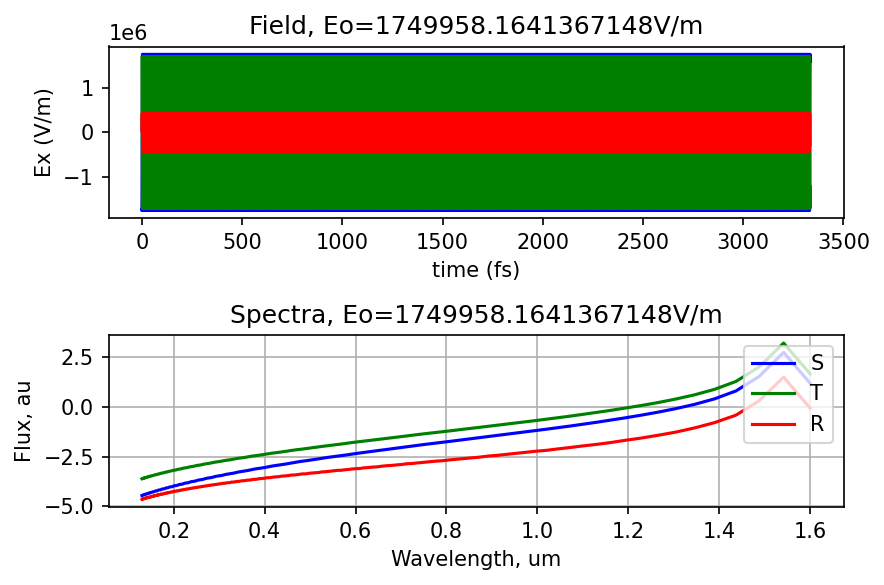

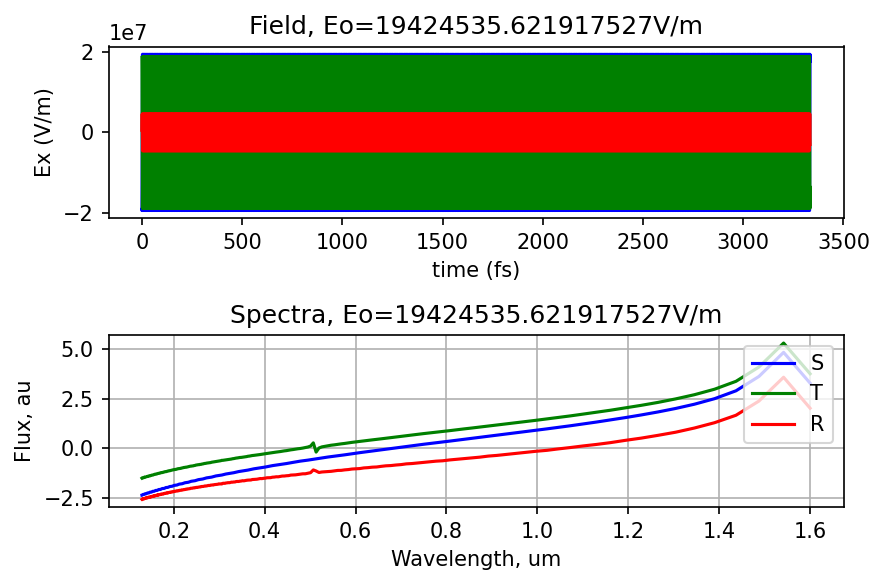

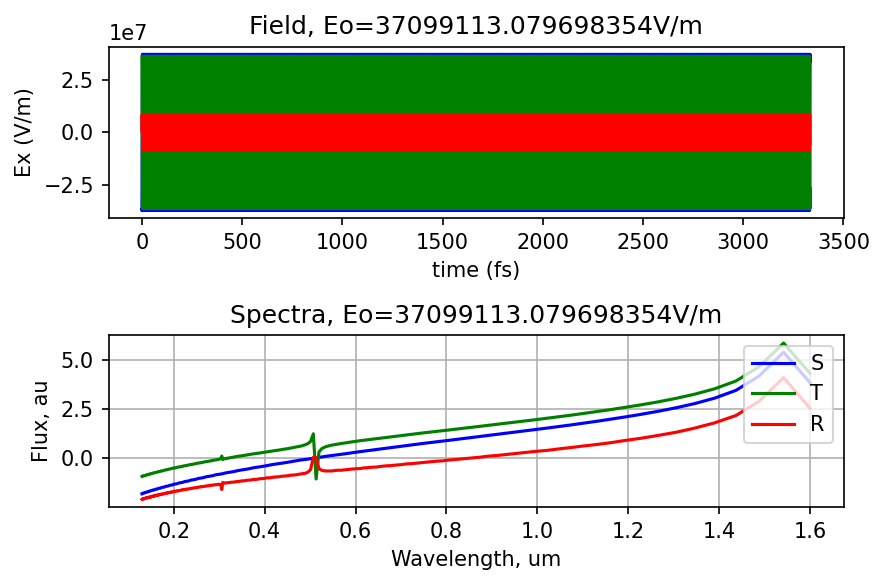

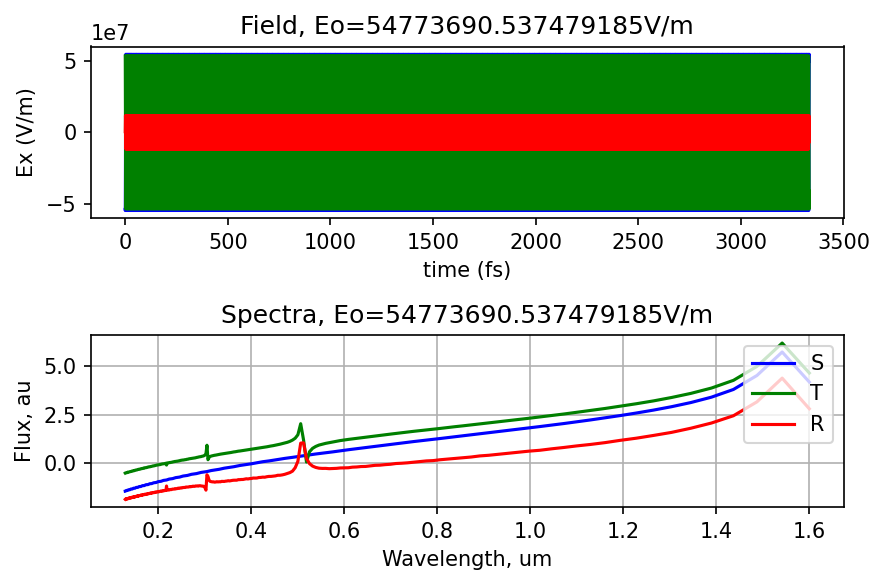

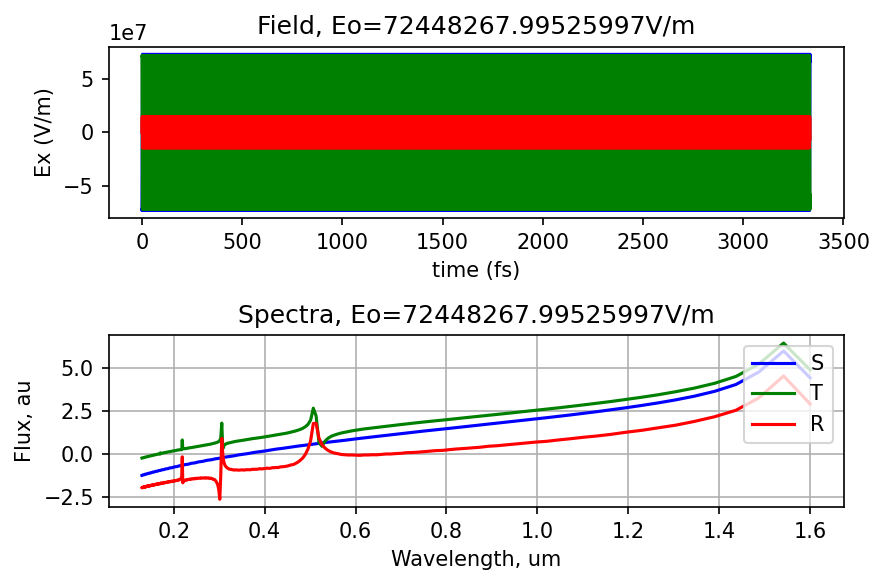

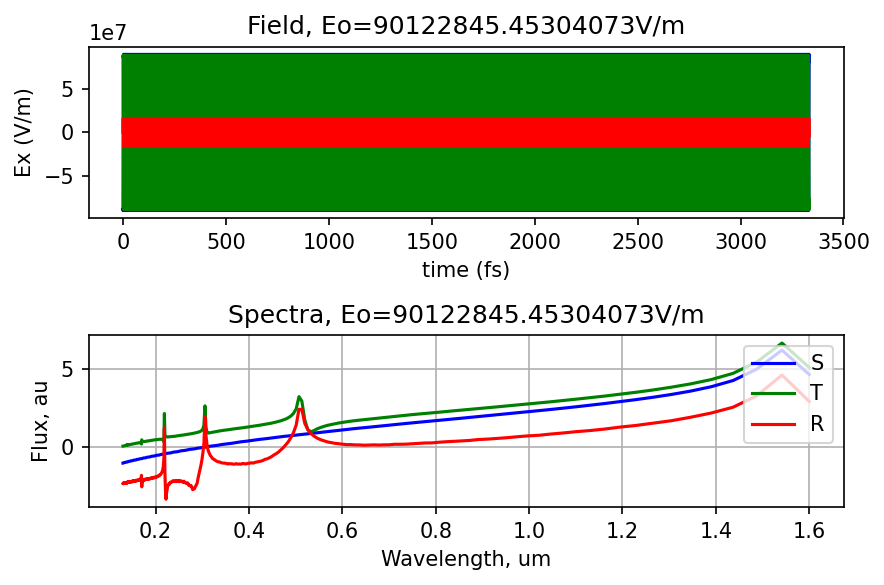

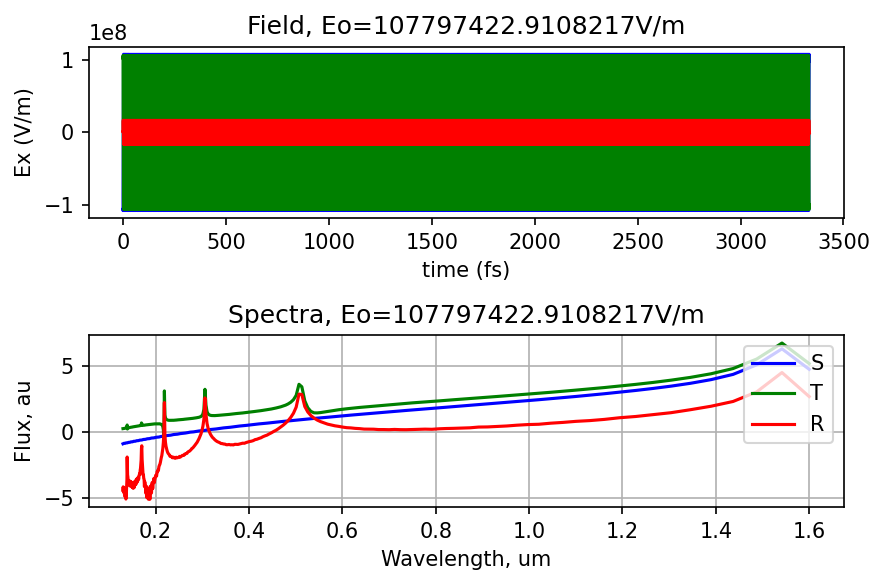

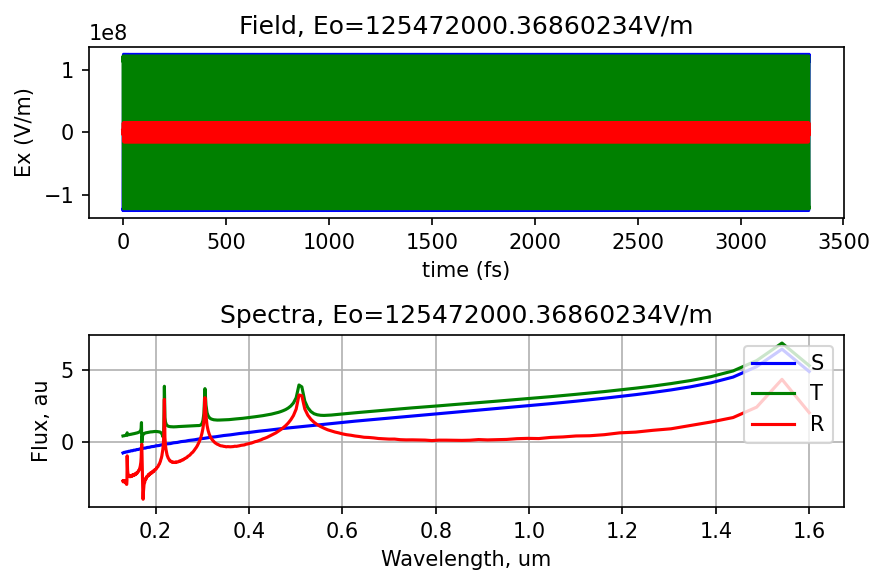

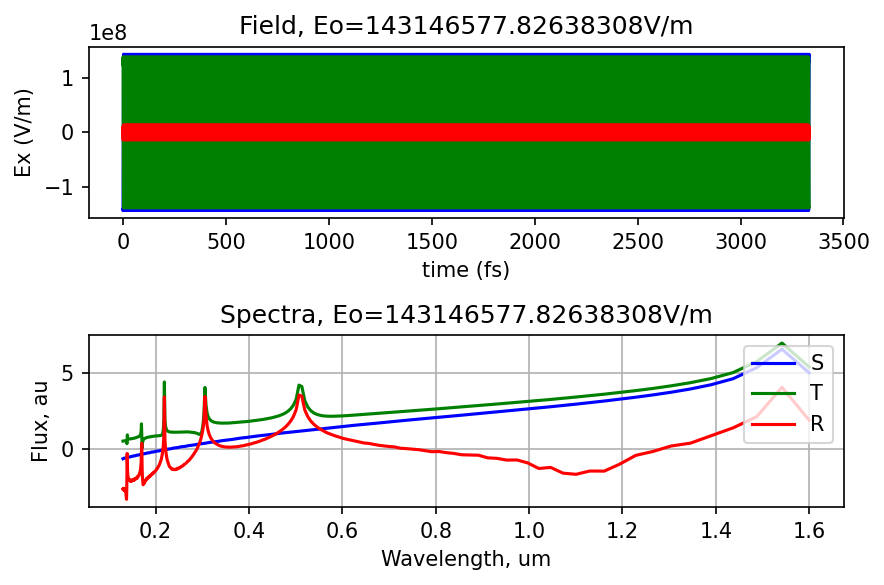

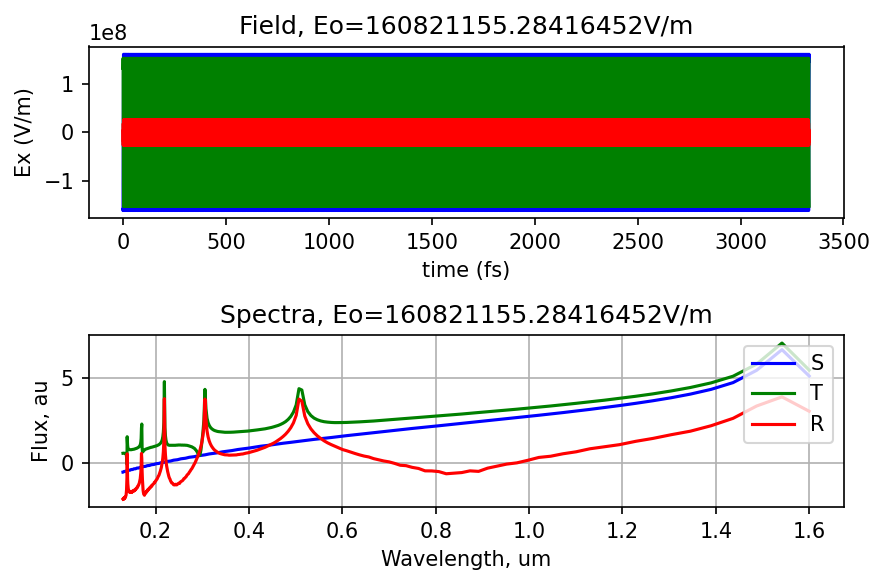

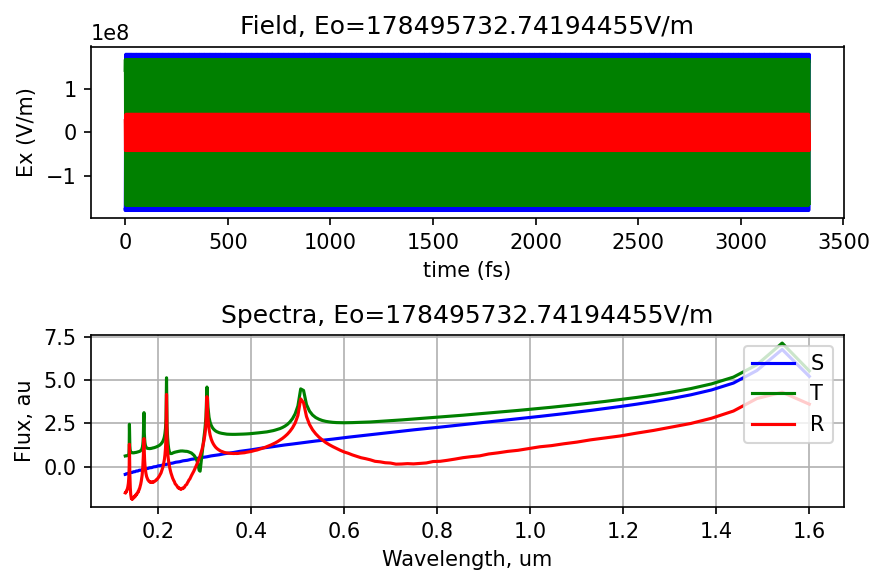

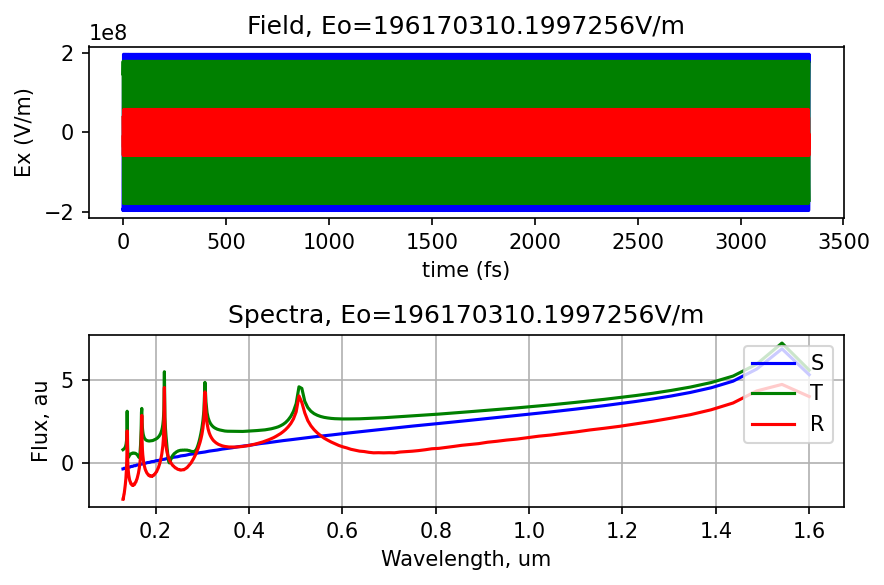

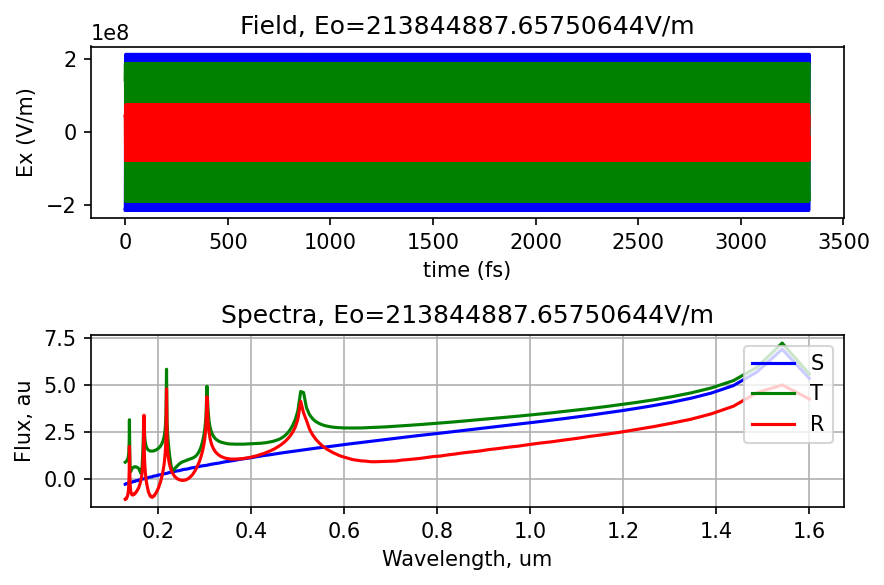

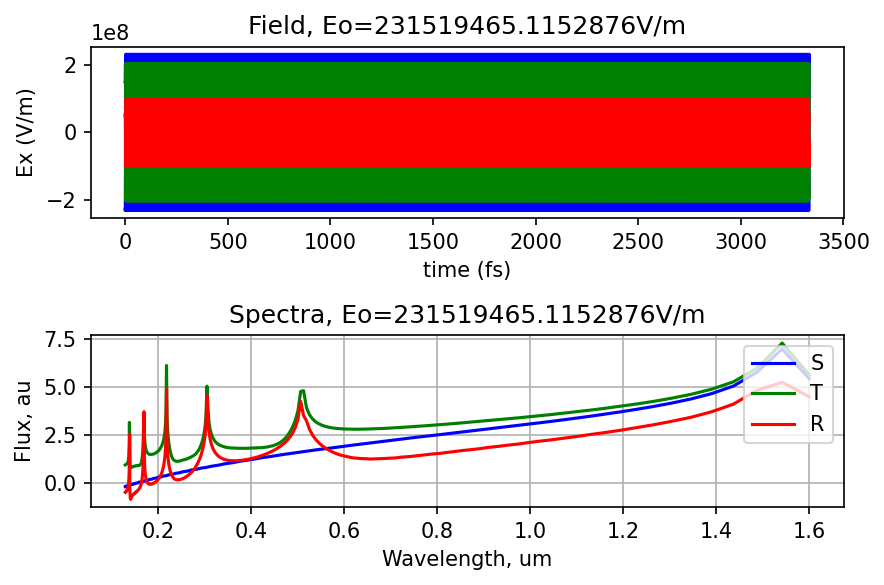

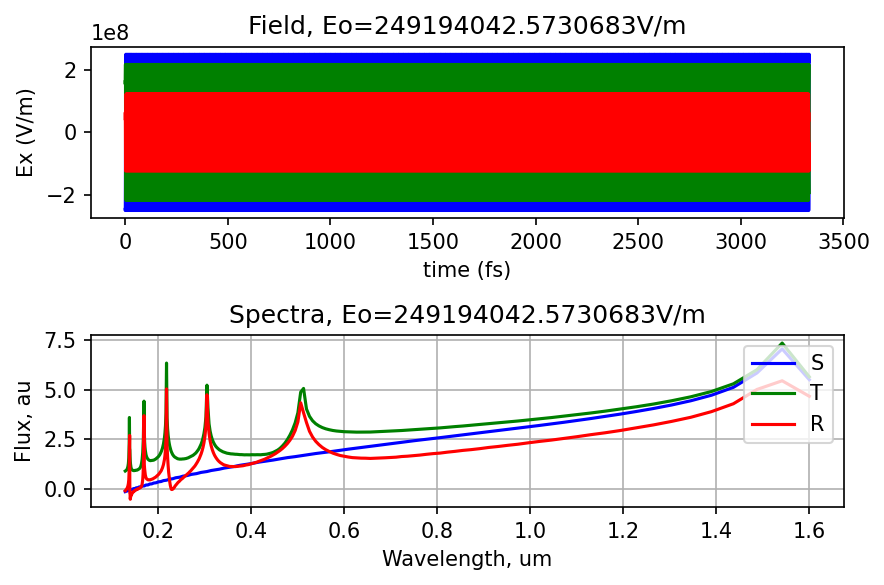

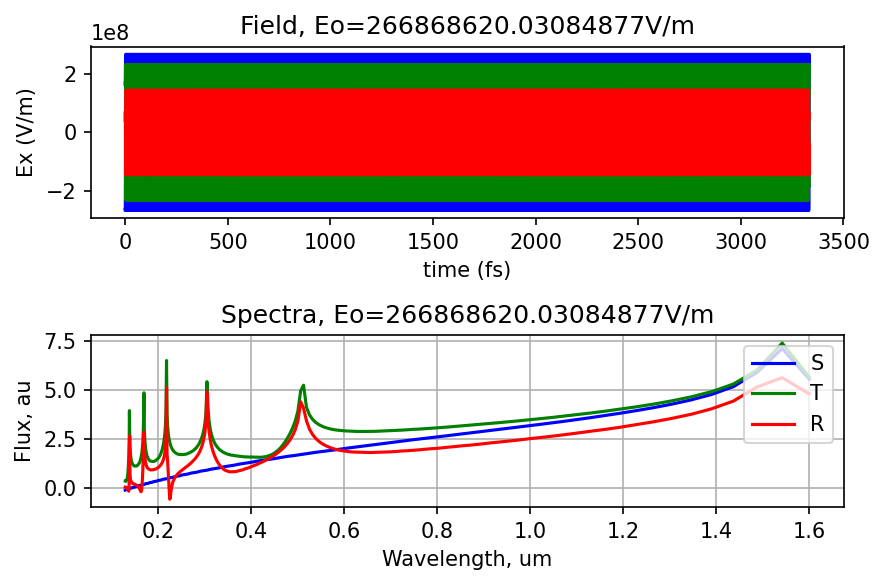

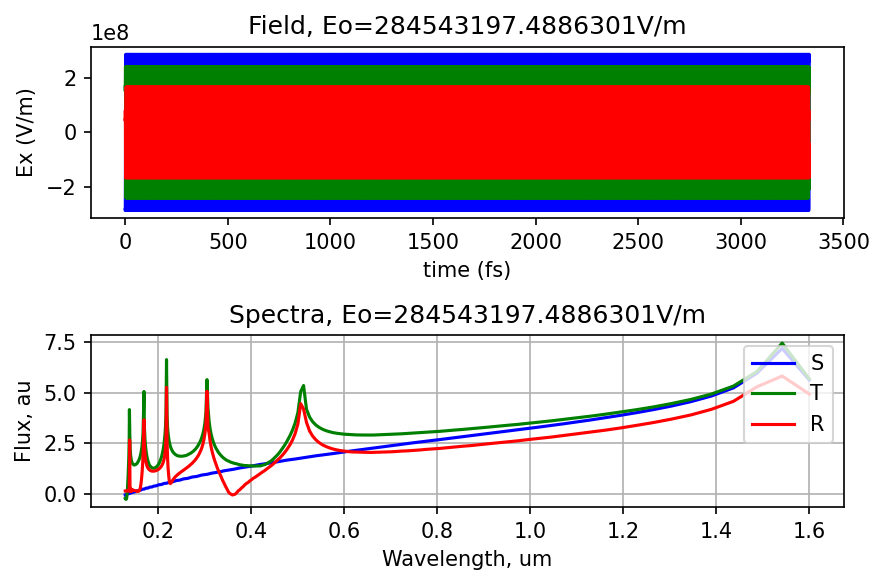

In [21]:
T_nl = np.empty(np.size(amp))
R_nl= np.empty(np.size(amp))
A_nl= np.empty(np.size(amp))
T_l= np.empty(np.size(amp))
R_l= np.empty(np.size(amp))
A_l= np.empty(np.size(amp))
E_out=np.empty(np.size(amp))
E_out2=np.empty(np.size(amp))
E_out3=np.empty(np.size(amp))
for j in range(np.size(amp)):
  print(j)
  E_out[j], E_out2[j], E_out3[j], plt_range, T_nl[j], R_nl[j], A_nl[j], T_l[j], R_l[j], A_l[j] = nl_cw(amp[j],resolution,k,n)

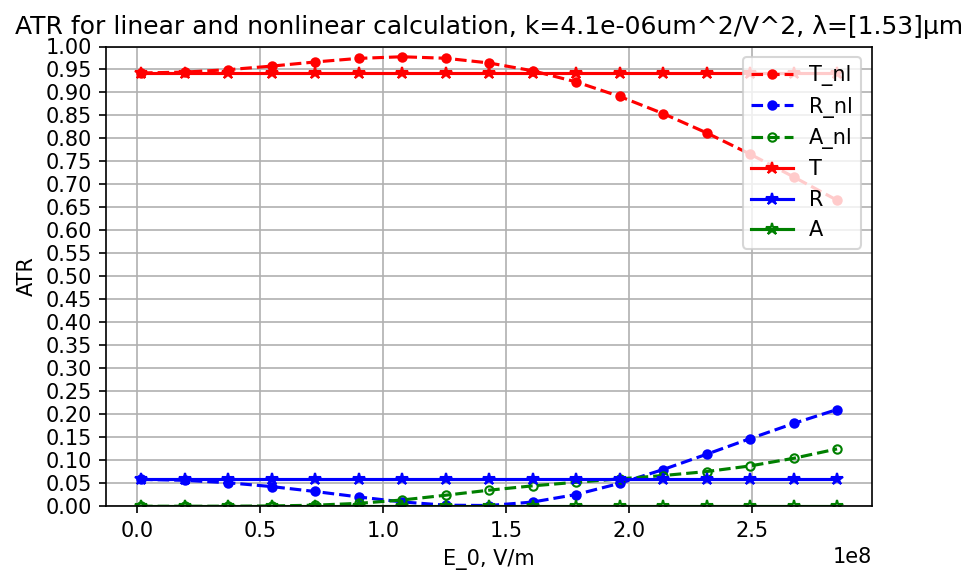

In [22]:
#         plot ATR
E_out[j], plt_range, T_nl[j], R_nl[j], A_nl[j], T_l[j], R_l[j], A_l[j]
plt.figure(dpi=150)
plt.plot(E_out,T_nl,'ro--',label='T_nl',markersize=4)
plt.plot(E_out,R_nl,'bo--',label='R_nl',markersize=4)
plt.plot(E_out,A_nl,'go--',label='A_nl',markersize=4, markerfacecolor='none')
plt.plot(E_out,T_l,'r*-',label='T')
plt.plot(E_out,R_l,'b*-',label='R')
plt.plot(E_out,A_l,'g*-',label='A', markerfacecolor='none')
plt.grid(True,which="both",ls="-")
#plt.xticks([0.2*10**8,0.4*10**8,0.6*10**8,0.8*10**8,1*10**8,1.2*10**8,1.2*10**8,1.4*10**8,1.6*10**8,1.8*10**8,2*10**8,2.2*10**8])
plt.yticks([-0.05,0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95, 1])
#plt.xlim([0.1*10**8,2.4*10**8])
plt.xlabel('E_0, V/m')
plt.ylabel('ATR')
plt.legend(loc='upper right')
#plt.xlim([0.85, 5])
plt.ylim([-0, 1])
plt.title('ATR for linear and nonlinear calculation, k='+str(f"{k:03}")+'um^2/V^2, λ='+str(f"{plt_range}")+'μm')
plt.tight_layout()
np.savetxt('ATR_vs_E0.txt', (E_out,T_nl,R_nl,A_nl), delimiter=',')

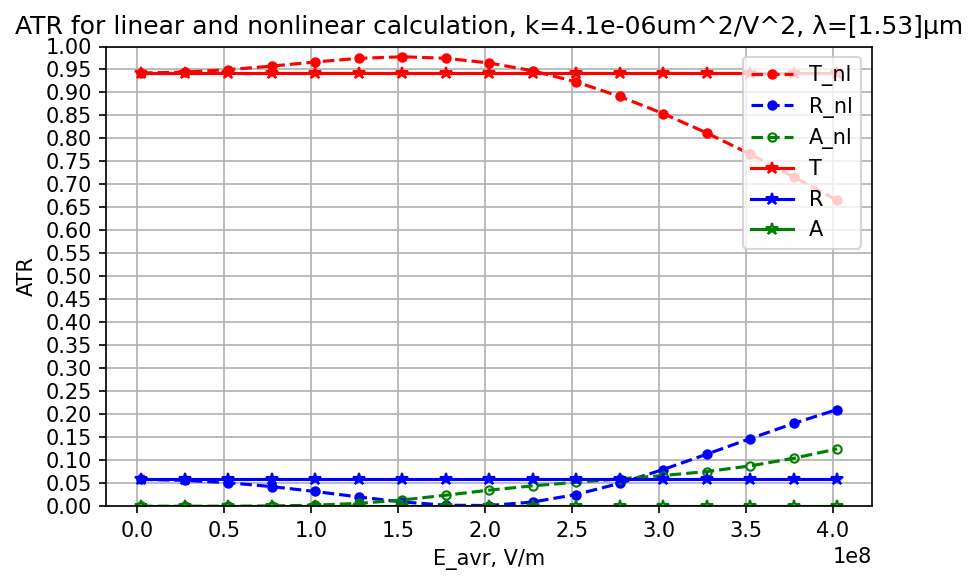

In [23]:
#         plot ATR
E_out[j], plt_range, T_nl[j], R_nl[j], A_nl[j], T_l[j], R_l[j], A_l[j]
plt.figure(dpi=150)
plt.plot(E_out*np.sqrt(2),T_nl,'ro--',label='T_nl',markersize=4)
plt.plot(E_out*np.sqrt(2),R_nl,'bo--',label='R_nl',markersize=4)
plt.plot(E_out*np.sqrt(2),A_nl,'go--',label='A_nl',markersize=4, markerfacecolor='none')
plt.plot(E_out*np.sqrt(2),T_l,'r*-',label='T')
plt.plot(E_out*np.sqrt(2),R_l,'b*-',label='R')
plt.plot(E_out*np.sqrt(2),A_l,'g*-',label='A', markerfacecolor='none')
plt.grid(True,which="both",ls="-")
plt.yticks([-0.05,0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95, 1])
plt.xlabel('E_avr, V/m')
plt.ylabel('ATR')
plt.legend(loc='upper right')
#plt.xlim([0.85, 5])
plt.ylim([-0, 1])
plt.title('ATR for linear and nonlinear calculation, k='+str(f"{k:03}")+'um^2/V^2, λ='+str(f"{plt_range}")+'μm')
plt.tight_layout()
np.savetxt('ATR_vs_Eav.txt', (E_out*np.sqrt(2),T_nl,R_nl,A_nl), delimiter=',')

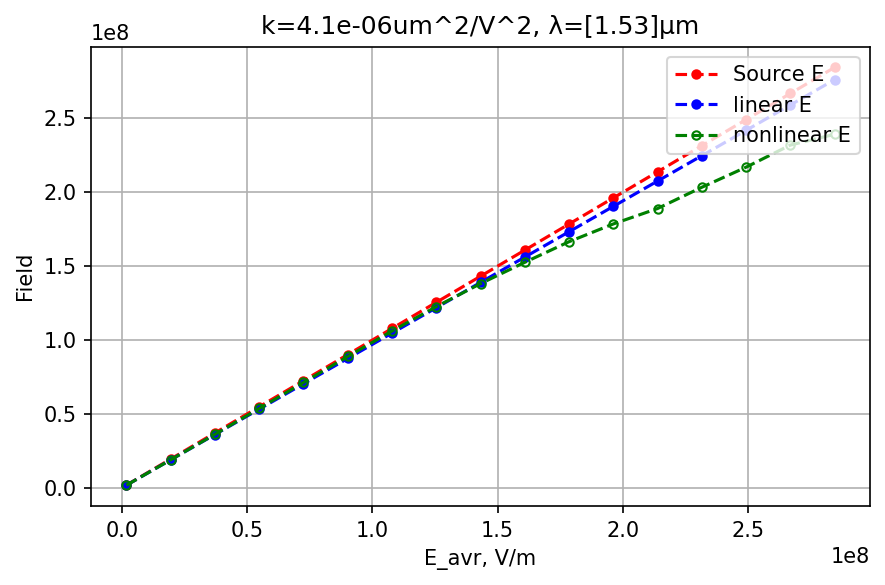

In [24]:
plt.figure(dpi=150)
plt.plot(E_out,E_out,'ro--',label='Source E',markersize=4)
plt.plot(E_out,E_out2,'bo--',label='linear E',markersize=4)
plt.plot(E_out,E_out3,'go--',label='nonlinear E',markersize=4, markerfacecolor='none')
plt.grid(True,which="both",ls="-")
plt.xlabel('E_avr, V/m')
plt.ylabel('Field')
plt.legend(loc='upper right')
#plt.xlim([0.85, 5])
#plt.ylim([-0, 1])
plt.title('k='+str(f"{k:03}")+'um^2/V^2, λ='+str(f"{plt_range}")+'μm')
plt.tight_layout()